### Imports, Power Spectra Compilation, and simulation (+CosMomentum) data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from math import *
from scipy import integrate
from scipy.optimize import fsolve
from classy import Class
from astropy.io import fits

import scienceplots
plt.style.use(['science','nature'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = [5,3]
plt.rcParams['lines.linewidth'] = 0.8

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Functions

In [2]:
# Choose your cosmology, redshift, Radius, and delta of interest

#Quijote Cosmologyical parameters
Omega_m = 0.3175
Omega_b = 0.049
h = 0.6711
n_s = 0.9624
sigma8 = 0.834

# Redshift
z = 0.5

# Radius
R = 5.0

# Delta_R
del_R = np.linspace(-0.99,40,num=2**10)
del_L = inverse_of_approximate_collapse_alex(del_R)
del_L_max = np.max(del_L)
del_L_min = np.min(del_L)
print(del_L_max)
print(del_L_min)



# Computing the power spectra
k_l,pk_l,k_nl,pk_nl = generate_all_power_spectra(Omega_m,
                                                 Omega_b,
                                                 h,
                                                 n_s,
                                                 sigma8,
                                                 z)

# Sigma generation, and testing of function
sR = sigma_from_power_spectrum(k_l, pk_l, R)
sR2 = np.square(sR)
print(sR)
print(sR2)
print(sigma_from_power_spectrum(k_nl, pk_nl, R))

1.4532461956534413
-26.333931165972125
generating power spectra ... (this will take time) ...
Done!
0.8675332370893332
0.7526139174546972
1.032469565133487


In [3]:
# del_qui_HR, pdf_qui_HR, std_qui_HR = load_quijote_sim("/project/ls-gruen/users/jamal.elkuweiss/Data/pdfs_quijote_fiducialHR_z"+str(z)+"_R"+str(R)+".npy",realisations=100)
del_qui, pdf_qui, std_qui = load_quijote_sim("/project/ls-gruen/users/jamal.elkuweiss/Data/Quijote_PDFs_15000_512CDMparticles/quijote_PDF_z"+str(z)+"_R"+str(R)+".npy")

In [4]:
# # plt.errorbar(del_qui_HR,pdf_qui_HR,yerr=std_qui_HR,elinewidth = 0.5,linewidth = 0.0,marker = "s",markersize = 0.1,capsize = 5,capthick = 0.5,c = "r",label = r"100 realisations / $1024^3$ CDM particles ",alpha=0.5)
# # plt.errorbar(del_qui,pdf_qui,yerr=std_qui,elinewidth = 0.5,linewidth = 0.0,marker = "s",markersize = 0.1,capsize = 5,capthick = 0.5,c = "k",label = r"15000 realisations / $512^3$ CDM particles",alpha=0.5)
# plt.errorbar(del_qui_HR,pdf_qui_HR,yerr=std_qui_HR, label = r"100 realisations / $1024^3$ CDM particles ")
# plt.errorbar(del_qui,pdf_qui,yerr=std_qui, label = r"15000 realisations / $512^3$ CDM particles")
# plt.title("Quijote Sims at two different resolutions / z = "+str(z)+" / R = "+str(R))
# plt.xlabel(r"$\delta_R$")
# plt.ylabel(r"$\mathcal{P}(\delta_R)$")
# plt.legend()
# plt.yscale("log")
# plt.xlim([-2,25])
# plt.grid("both")

In [5]:
# Loading data generated by Cosmomentum
CM_delta = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/CosMom/delta_quijote_z"+str(z)+"_R"+str(int(R))+"_CosMom.npy")
CM_PDF = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/CosMom/PDF_quijote_z"+str(z)+"_R"+str(int(R))+"_CosMom.npy")

In [6]:
Sigma_L_on_NL = np.square(sigma_from_power_spectrum(k_l, pk_l, R)) / np.square(sigma_from_power_spectrum(k_nl, pk_nl, R))
print(r"$\Sigma_{R}^{L,R}$ = " + str(Sigma_L_on_NL))

$\Sigma_{R}^{L,R}$ = 0.7060211774183793


/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1
/scratch-local/slurm-job-tmp-4088301/ipykernel_310/168325280.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(EdS_collapse[0], np.abs((approximate_collapse_alex(EdS_collapse[0]) - EdS_collapse[1]) / EdS_collapse[1]))


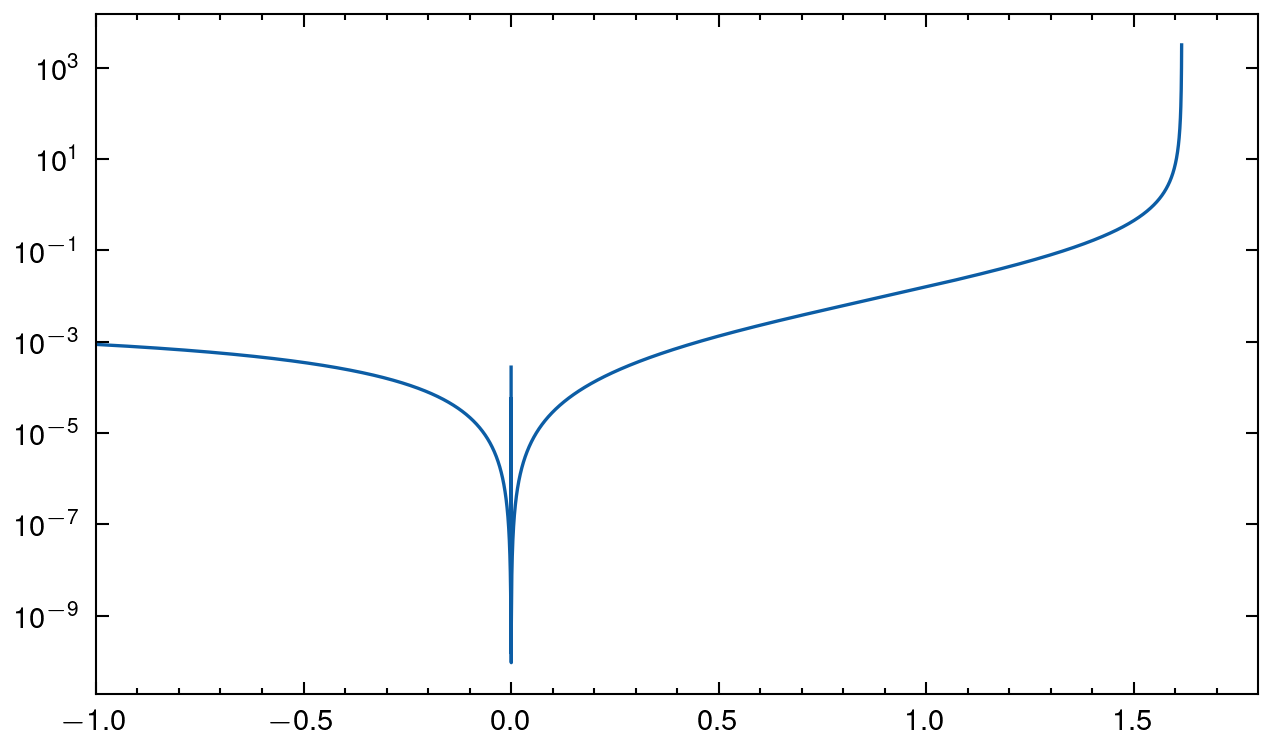

In [7]:
EdS_collapse = np.loadtxt("/project/ls-gruen/users/jamal.elkuweiss/Data/pretabulated_data_for_EdS/EdS_spherical_collapse.dat", delimiter = " ")
EdS_collapse = np.transpose(EdS_collapse)
# plt.plot(EdS_collapse[0],lw=0,marker='s')
# plt.plot(EdS_collapse[0],EdS_collapse[1])
plt.plot(EdS_collapse[0], np.abs((approximate_collapse_alex(EdS_collapse[0]) - EdS_collapse[1]) / EdS_collapse[1]))
plt.xlim([-1,1.8])
# plt.ylim([-4,400])
plt.yscale("log")

### CGFs and Characteristic functions

In [48]:
def derivative_with_same_axis(x,y):
    y_array = []
    x_array = []

    for i in range(len(x)-2):
        d_y = y[i+2] - y[i]
        d_x = x[i+2] - x[i]
        y_array += [d_y]
        x_array += [d_x]
    y_array = np.array(y_array)
    x_array = np.array(x_array)
    y_array = y_array/x_array
    return y_array

def RCGF_at_the_saddle2(kl, pl, knl, pnl, R, delta_min=-10, delta_max=1.8):
    # Expression of the CGF equated at the saddle point of the action (equation [5] of https://arxiv.org/abs/1912.06621)
    Lam = []  # lambda values
    cgf = []  # CGF values
    t1 = []
    t2 = []
    t3 = []

    # The actual delta values that we return
    delta_L = np.linspace(delta_min, delta_max, num=2 ** 13)

    for delta in delta_L:
        # collapses
        F = approximate_collapse_alex(delta)
        Fp = derivative_of_approximate_collapse_alex(delta)
        # Lagrange Radius
        Rl = np.power(1 + F, 1 / 3) * R
        # sigmas
        sR  = sigma_from_power_spectrum(kl, pl, R)
        sRl = sigma_from_power_spectrum(kl, pl, Rl)
        # sigma squares
        sRl2 = np.square(sRl)
        sR2 = np.square(sR)

        # jstar as a function of detla
        j = delta / sRl2
        # value of the lambda
        R_factor = Rl/(3*(1+F))
        lam = ((sR2*j)/Fp) - 0.5*((j*sR)**2)*R_factor*(del_variance(kl, pl, Rl))
        
        Lam += [lam]
        cgf += [(lam * F) - (j * delta * sR2) + (0.5 * (j**2) * sRl2 * sR2)]
        t1 += [(lam * F) ]
        t2 += [- (j * delta * sR2)]
        t3 += [(0.5 * (j**2) * sRl2 * sR2)]
    Lam = np.array(Lam)
    cgf = np.array(cgf)

    var_ratio = 1 / np.square(sigma_from_power_spectrum(knl, pnl, R))
    # Rescaling both the cgf values and the lambda values to get the non linear RCGF scaling
    cgf = cgf * var_ratio
    Lam = Lam * var_ratio
    
    cgfp = derivative_with_same_axis(Lam,cgf)
    cgfpp = derivative_with_same_axis(Lam[1:-1],cgfp)
    # cgfppp = derivative_with_same_axis(Lam[2:-2],cgfpp)
    # cgfpppp = derivative_with_same_axis(Lam[3:-3],cgfppp)
    
    Psi = Lam[1:-1] * cgfp - cgf[1:-1]
    Psi_1 = Lam[1:-1]
    Psi_2 = derivative_with_same_axis(cgfp,Psi_1)
    Psi_3 = derivative_with_same_axis(cgfp[1:-1],Psi_2)
    Psi_final = np.array([Psi[2:-2], Psi_1[2:-2], Psi_2[1:-1], Psi_3])

    return delta_L[2:-2], Lam[2:-2], cgf[2:-2], cgfp[1:-1], cgfpp, Psi_final, np.array(t1[2:-2]), np.array(t2[2:-2]), np.array(t3[2:-2])
    # return delta_L[4:-4], Lam[4:-4], cgf[4:-4], cgfp[3:-3], cgfpp[2:-2], cgfppp[1:-1], cgfpppp

In [49]:
# delta_L, lam, cgf, cgfp, cgfpp, Psi_from_legendre = RCGF_at_the_saddle2(k_l, pk_l, k_nl, pk_nl, R, delta_max=1.3)
delta_L, lam, cgf, cgfp, cgfpp, Psi_from_legendre, t1, t2 ,t3 = RCGF_at_the_saddle2(k_l, pk_l, k_nl, pk_nl, R)
# delta_L, lam, cgf, cgfp, cgfpp, cgfppp, cgfpppp = RCGF_at_the_saddle2(k_l, pk_l, k_nl, pk_nl, R, delta_max=1.2)

/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:24: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu - 1)


/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1


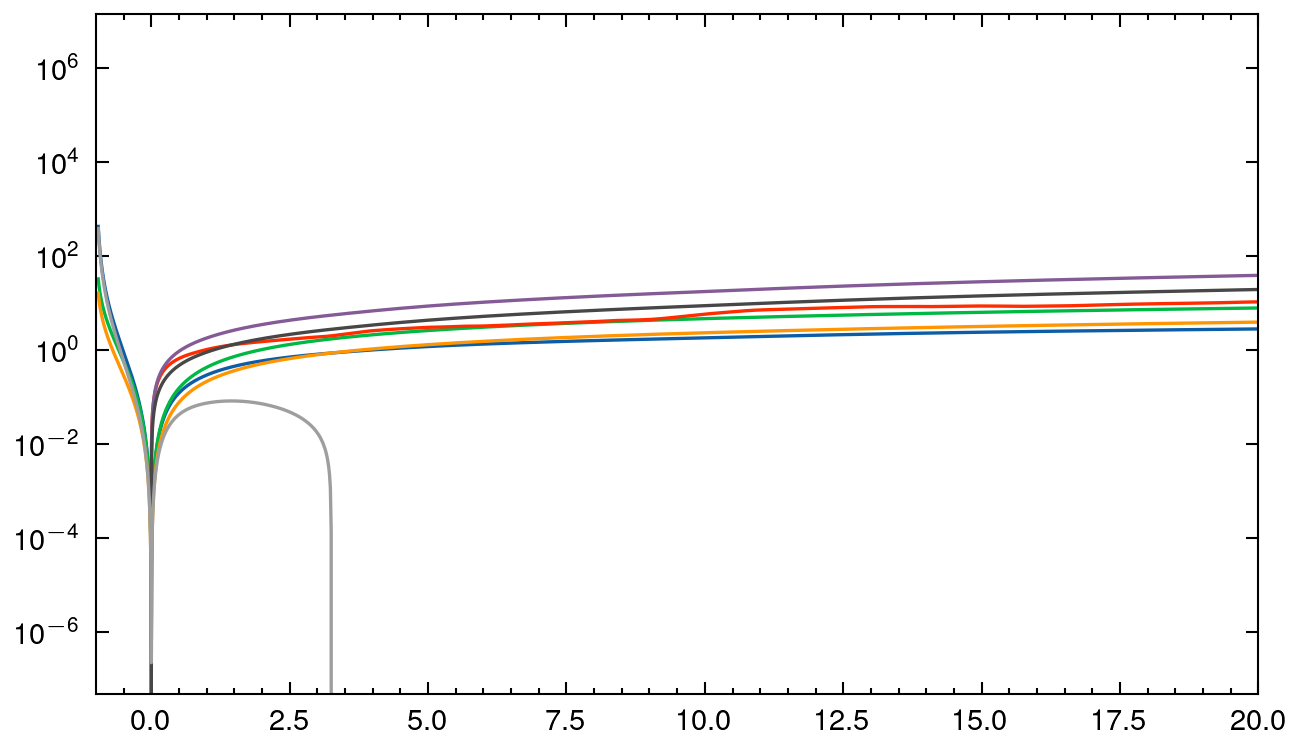

In [50]:
plt.plot(approximate_collapse_alex(delta_L),t1)
plt.plot(approximate_collapse_alex(delta_L),-t2)
plt.plot(approximate_collapse_alex(delta_L),t3)

plt.plot(approximate_collapse_alex(delta_L)[1:-1], derivative_with_same_axis(delta_L,t1))
plt.plot(approximate_collapse_alex(delta_L)[1:-1], derivative_with_same_axis(delta_L,-t2))
plt.plot(approximate_collapse_alex(delta_L)[1:-1], derivative_with_same_axis(delta_L,t3))
plt.plot(approximate_collapse_alex(delta_L), cgf)

# plt.plot(lam, t1-t2+t3)
# plt.plot(lam, cgf)

# plt.plot(approximate_collapse_alex(delta_L),cgf)
# plt.plot(approximate_collapse_alex(delta_L),cgfpp)
# plt.plot(approximate_collapse_alex(delta_L),lam*derivative_of_approximate_collapse_alex(delta_L))
# plt.plot(approximate_collapse_alex(delta_L)[1:-1],derivative_with_same_axis(lam,delta_L))
plt.xlim([-1,20])
# plt.ylim([-1,50])
plt.yscale('log')

In [51]:
# This should be the critical rho, included here just for testing
print(np.interp(1.02,lam,cgfp))
print(np.interp(0.9,lam,cgfp))

nan
nan


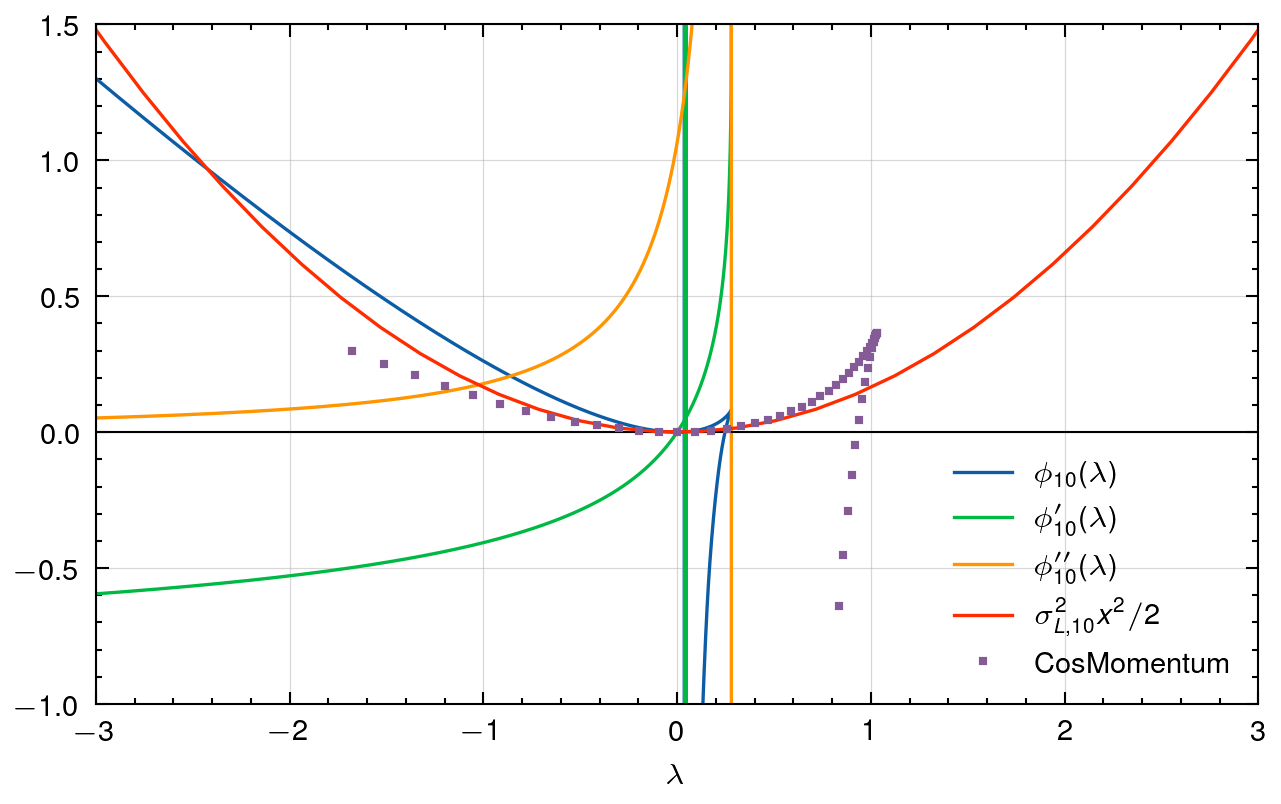

In [52]:
plt.plot(lam,cgf,label=r'$\phi_{10}(\lambda)$')#, c=colors[0], ls='dashed')
plt.plot(lam,cgfp,label=r'$\phi^{\prime}_{10}(\lambda)$')#, c=colors[0], ls='dashed')
plt.plot(lam[:-700],cgfpp[:-700],label=r'$\phi^{\prime \prime}_{10}(\lambda)$')#,c=colors[0], ls='dotted')

plt.plot(np.linspace(-10,10,2),[0,0],c='k',lw=0.5)

plt.plot(np.linspace(-5,5),0.5*(0.3289095388158506)*np.square(np.linspace(-5,5)),label="$\sigma_{L,10}^2x^2 / 2$")#,c = 'grey')

lam_cm = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/lamda_R10_z05.npy")
cgf_cm = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/cgf_R10_z05.npy")
plt.plot(lam_cm[::4],cgf_cm[::4],lw=0,label="CosMomentum",marker='s',markersize=1)#,c=colors[3])


plt.xlim([-3,3])
plt.ylim([-1,1.5])

plt.xlabel(r'$\lambda$')
plt.grid(alpha=0.5,lw=0.3)
plt.legend()
# plt.title("RCGF and its second derivative")
# plt.savefig("cgfvsCM.pdf")

In [53]:
print(sigma_from_power_spectrum(k_nl, pk_nl, R)**2 - np.interp(0,lam,cgfpp))
print(np.interp(0,lam,cgf))
print(np.interp(0,lam,cgfp))
print(np.interp(0,lam,cgfpp))

-4.49432292870533e-06
2.42725070177107e-07
1.0939592452003863e-07
1.0659978972498605


/scratch-local/slurm-job-tmp-4088301/ipykernel_310/151283781.py:5: RuntimeWarning: invalid value encountered in sqrt
  pdf_saddle = np.exp( ratio*((-lam*cgfp) + cgf) ) / np.sqrt(2 * np.pi * cgfpp * (1/ratio))


Text(0, 0.5, '$\\mathcal{P}(\\delta_R)$')

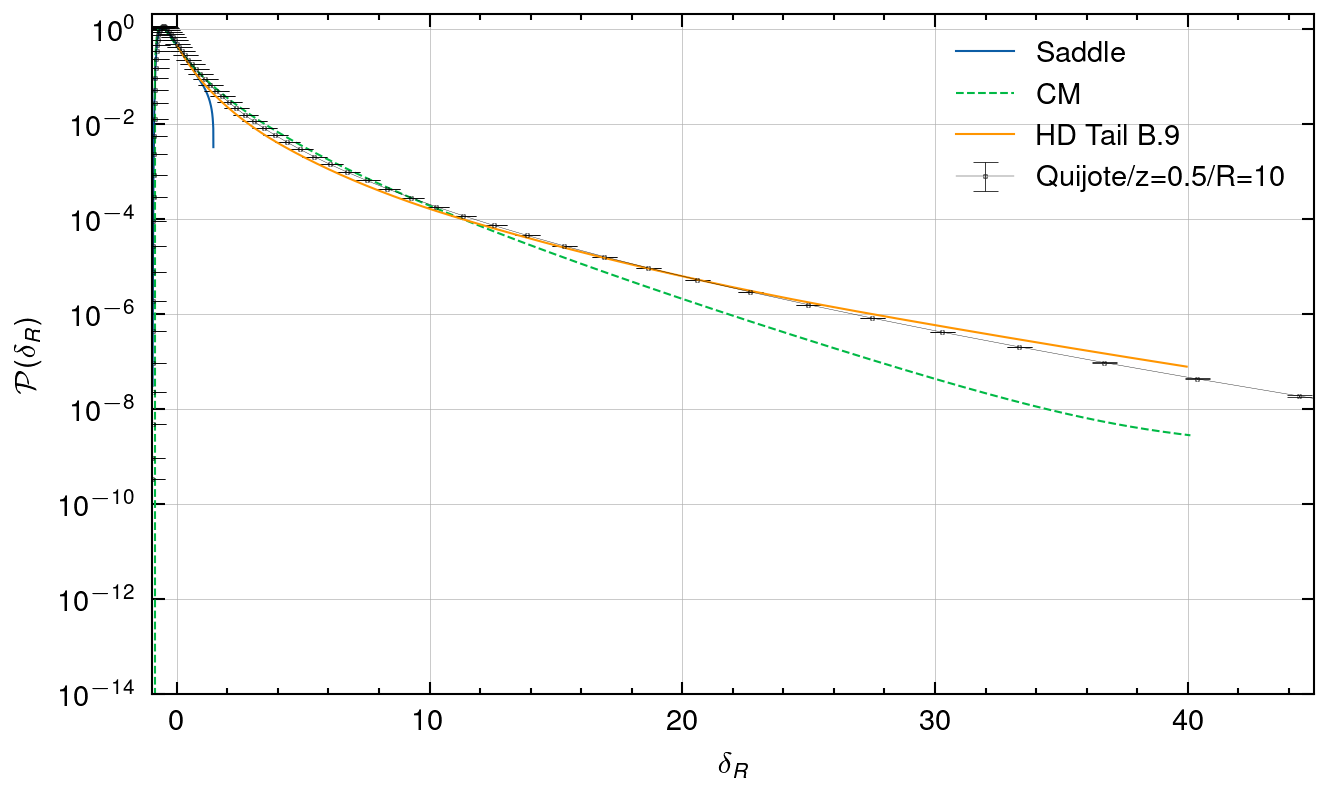

In [54]:
# Saddle point approx
VLR  = np.square(sigma_from_power_spectrum(k_l, pk_l, R))
VR  = np.square(sigma_from_power_spectrum(k_nl, pk_nl, R))
ratio = VR / VLR
pdf_saddle = np.exp( ratio*((-lam*cgfp) + cgf) ) / np.sqrt(2 * np.pi * cgfpp * (1/ratio))
# corr1 = (1/(8*ratio)) * (cgfpppp/np.square(cgfpp))
# corr2 = (5/24) * (1/ratio) * (np.power(cgfppp,2)/np.power(cgfpp,3))
# pdf_saddle1 = pdf_saddle1*(1 - corr1 + corr2)


# Valageas HD Tail
hdtail = high_density_tail_ValIIB9(del_R,k_l,pk_l,R)



graph_thicc = 0.5

plt.plot(cgfp,pdf_saddle, lw=graph_thicc, label="Saddle")#,marker = 's',ms=0.5)
plt.plot(CM_delta,       CM_PDF,   label='CM', lw=graph_thicc, ls = "dashed")
plt.errorbar(del_qui,pdf_qui,
             yerr=std_qui,
             elinewidth = 0.2,
             linewidth = 0.1,
             marker = "s",
             markersize = 0.01,
             capsize = 3,
             capthick = 0.2,
             c = "k",
             label = "Quijote/z=0.5/R=10",
             alpha=0.9)

indx = int(np.where(del_R>0)[0][0])
plt.plot(del_R[indx:-1],hdtail[indx:-1],label="HD Tail B.9",lw=graph_thicc)

plt.yscale("log")
plt.xlim([-1, 45])
plt.ylim([1e-14, 2])
plt.legend()
plt.grid(alpha=0.8,lw=0.2)
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathcal{P}(\delta_R)$')

In [55]:
# Here we try to calcuate the B7 equation from valageas by taking the values of delta from the RCGF generation
# THE VALUE AT WHICH THE CUT HAPPENS HAS TO BE CHANGED MANUALLY EVERYTIME!

a = np.where(lam > 1.024068670927916)
print(a)

def pdf_from_deltaL_range(deltaL):
    tau = []
    sRl = []
    for dl in deltaL:
        d = approximate_collapse_alex(dl)
        Rl = np.power(1 + d, 1 / 3) * R
        sRl = sigma_from_power_spectrum(k_l, pk_l, Rl)
        tau += [-dl * (sR/sRl)]
        sRl += [sRl]
    
    tau = np.array(tau)
    sRl = np.array(sRl)
    
    d = approximate_collapse_alex(deltaL)
    # d = approximate_collapse_alex(  - tau * ( sRl / sR ) )
    
    d_delR_d_tau = np.diff(d)/np.diff(tau)
    new_tau = 0.5 * (tau[1:] + tau[:-1])
    
    h1 = 1 / (np.sqrt(2*pi)*sR)
    h2 = 1 / (1 + d)
    h3 = 1 / np.abs(np.interp(tau,new_tau,d_delR_d_tau))
    h4 = np.exp(-np.square(tau) / (2*sR2))
    
    return d, h1*h2*h4*h3

d1,P1 = pdf_from_deltaL_range(delta_L[0:7619])
d2,P2 = pdf_from_deltaL_range(delta_L[7619:-1])
d3,P3 = pdf_from_deltaL_range(delta_L)

(array([], dtype=int64),)


/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1


Text(0, 0.5, '$\\mathcal{P}(\\delta_R)$')

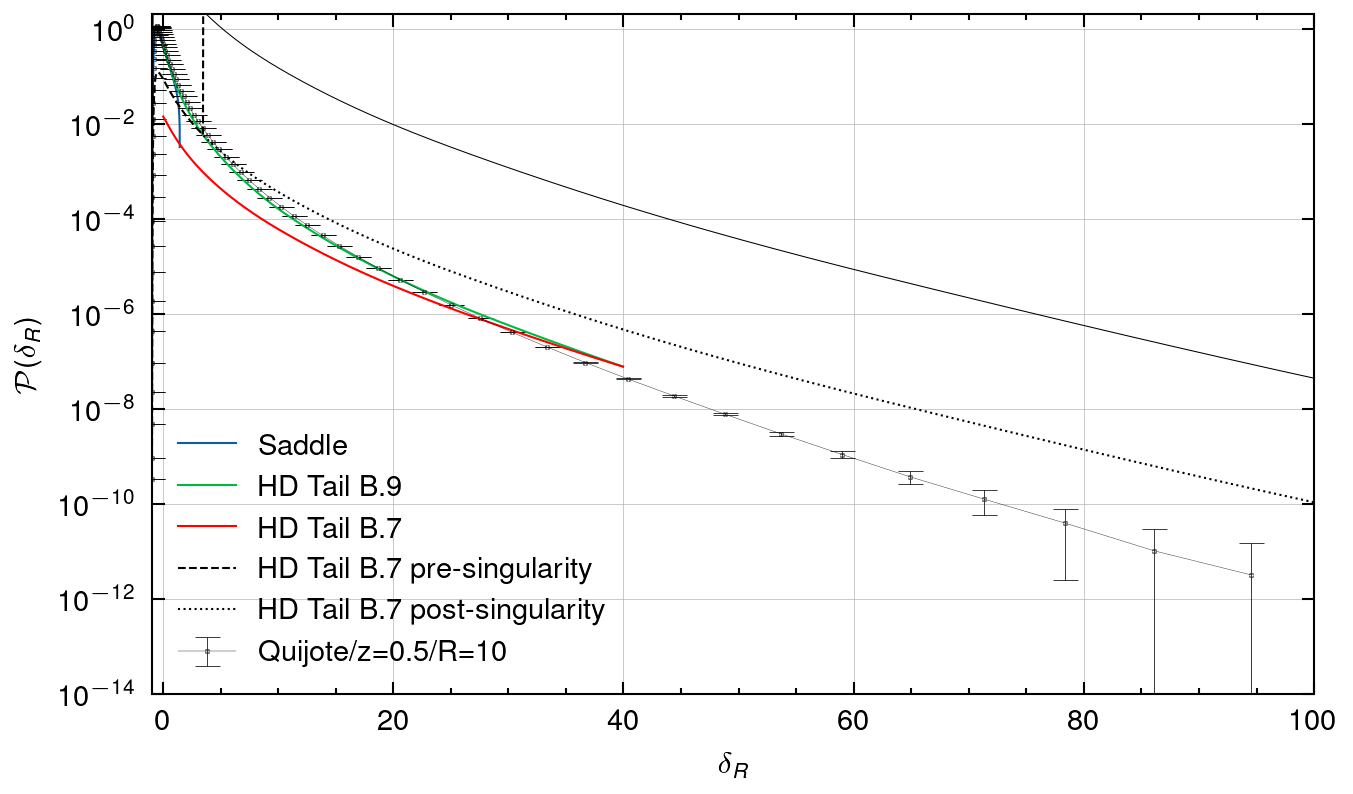

In [68]:
graph_thicc = 0.5

plt.plot(cgfp,pdf_saddle, lw=graph_thicc, label="Saddle")#,marker = 's',ms=0.5)
# plt.plot(CM_delta,       CM_PDF,   label='CM', lw=graph_thicc, ls = "dashed")
plt.errorbar(del_qui,pdf_qui,
             yerr=std_qui,
             elinewidth = 0.2,
             linewidth = 0.1,
             marker = "s",
             markersize = 0.01,
             capsize = 3,
             capthick = 0.2,
             c = "k",
             label = "Quijote/z=0.5/R=10",
             alpha=0.9)

indx = int(np.where(del_R>0)[0][0])
plt.plot(del_R[indx:-1],hdtail[indx:-1],label="HD Tail B.9",lw=graph_thicc)
plt.plot(del_R[indx:-1],high_dens_b7(del_R,k_l,pk_l,R)[indx:-1],lw=graph_thicc,c='r',label = 'HD Tail B.7')
plt.plot(d1,P1,c='k',ls='dashed',lw=graph_thicc,label='HD Tail B.7 pre-singularity')
plt.plot(d2,P2,c='k',ls='dotted',lw=graph_thicc,label='HD Tail B.7 post-singularity')
plt.plot(d3,P3,c='k',lw=graph_thicc/2)

plt.yscale("log")
# plt.xlim([-1, 3])
# plt.ylim([1e-2, 3])
plt.xlim([-1, 100])
plt.ylim([1e-14, 2])
plt.legend()
plt.grid(alpha=0.8,lw=0.2)
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathcal{P}(\delta_R)$')

# Rate function from definition with polynomial approximation

In [18]:

p_0 = []
# var_ratio = np.square(sigma_from_power_spectrum(k_l, pk_l, R)) / np.square(sigma_from_power_spectrum(k_nl, pk_nl, R))
var_ratio = 1
print(var_ratio)
for d in r_poly:
    RL = np.power(1 + d, 1 / 3) * R
    p_0 += [(1 / (2*np.square(sigma_from_power_spectrum(k_l, pk_l, RL)))) * np.square(inverse_of_approximate_collapse_alex(d))]
p_0 = np.array(p_0)*var_ratio

1


NameError: name 'r_poly' is not defined

In [ ]:
rank = 11
r_poly = np.linspace(0.4,10,2**14)
psi0_poly = np.polyfit(r_poly, np.interp(r_poly,rho_num_deriv,p_num_deriv[2,:]), rank)

In [ ]:
# plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=0),r_poly),lw=0.5,label=r'$\Psi^{(0)}$')
# plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=1),r_poly),lw=0.5,label=r'$\Psi^{(1)}$')
# plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=2),r_poly),lw=0.5,label=r'$\Psi^{(2)}$')
# plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=3),r_poly),lw=0.5,label=r'$\Psi^{(3)}$')
for i in range(5):
    plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=i),r_poly))
    plt.plot(rho_num_deriv,p_num_deriv[i+2,:],alpha=0.2,c='k',lw=1)
plt.ylim([-3,3])
plt.xlim([-1,4])
# plt.xlim([1,2])
plt.grid(alpha=0.8,lw=0.4)
# plt.legend()

In [ ]:
roots_order2 = np.roots(np.polyder(psi0_poly,m=2))
roots_order2 = roots_order2[np.where(roots_order2 == np.real(roots_order2))]
roots_order2 = roots_order2[np.where(roots_order2 > 0)]
print(np.absolute(roots_order2))

In [ ]:
rho_c = np.absolute(roots_order2) 
rho_c = 1.68216257

lam_c = np.polyval(np.polyder(psi0_poly,m=1),rho_c)
# lam_c = 1.1

print(lam_c)
print(np.interp(lam_c, lam, cgfp))
cgf_c = np.interp(lam_c, lam, cgf)

pi_3 = np.array(np.polyval(np.polyder(psi0_poly,m=3),rho_c),dtype=np.complex_)
pi_4 = np.array(np.polyval(np.polyder(psi0_poly,m=4),rho_c),dtype=np.complex_)
pi_5 = np.array(np.polyval(np.polyder(psi0_poly,m=5),rho_c),dtype=np.complex_)
pi_6 = np.array(np.polyval(np.polyder(psi0_poly,m=6),rho_c),dtype=np.complex_)
pi_7 = np.array(np.polyval(np.polyder(psi0_poly,m=7),rho_c),dtype=np.complex_)

a32 = (2/3) * np.sqrt(2 / pi_3)
a52 = (np.power(1/pi_3, 7/2) * (5*np.square(pi_4) - 3*pi_3*pi_5)) / (45*sqrt(2))
a2  = pi_4 / (6*np.square(pi_3))
a72 = (np.power(1/pi_3,13/2) * ( (385*np.power(pi_4,4)) - (630*pi_3*pi_5*np.power(pi_4,2) + (168*pi_6*pi_4*np.power(pi_3,2) + (3*np.power(pi_3,2)*((35*np.power(pi_5,2)) - (8*pi_3*pi_7))))) )) / (7560*sqrt(2))

r1 = -(np.imag(a52)/np.imag(a32)) - rho_c
r2 = -(7*((2*a2*np.power(a32,2)) + (2*a72*a32) - (np.power(a52,2)))) / (4*np.power(a32,2))

P_1 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*cgfp) ) / (4*np.sqrt(pi)*np.power(cgfp + 0,5/2))
P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*cgfp) ) / (4*np.sqrt(pi)*np.power(cgfp + r1,5/2))
P_3 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*cgfp) ) / (4*np.sqrt(pi)*np.power(cgfp + np.absolute(r1) + (np.absolute(r2)/cgfp),5/2))

P_46 = (1/sqrt(2*pi)) * np.sqrt(p[2,:]) * np.exp(- p[0,:])

print("--------------------------------")
print(pi_3)
print(pi_4)
print(pi_5)
print(pi_6)
print(pi_7)
print("--------------------------------")
print(a32)
print(a2)
print(a52)
print(a72)
print("--------------------------------")
print(r1)
print(r2)
print("--------------------------------")
print(P_1)
print(P_2)
print(P_3)
print("--------------------------------")

In [ ]:
# plt.plot(cgfp[0:7450],pdf[0:7450], lw=0.7, label="approx.")
plt.plot(cgfp,pdf_saddle, lw=0.5, label="Saddle approx.")

plt.plot(cgfp -1,P_1,label="Bern. LO", lw = 0.5,ls = "dashed")
plt.plot(cgfp-1,P_2,label="Bern. NLO", lw = 0.5,ls = "dashed")
plt.plot(cgfp-1,P_3,label="Bern. NNLO", lw = 0.5,ls = "dashed")

plt.plot(r-1,P_46,label='Bern. 46',lw=0.5)

plt.plot(CM_delta,       CM_PDF,   label='CosMomentum', lw=0.5)
# plt.scatter(del_qui,pdf_qui,lw = 0,label="Quijote", s = 2, c='k', marker = 's')
plt.errorbar(del_qui,pdf_qui,
             yerr=std_qui,
             elinewidth = 0.2,
             linewidth = 0.1,
             marker = "s",
             markersize = 0.01,
             capsize = 3,
             capthick = 0.2,
             c = "k",
             label = "Quijote/z=0.5/R=10",
             alpha=0.9)
plt.plot(del_R,hdtail,label="HD tail",lw=0.5)


plt.yscale("log")

# close up
# plt.xlim([-1.5, 5])
# plt.ylim([1e-4, 2])

# Overview
plt.xlim([-1.3, 25])
plt.ylim([1e-14, 10e1])

# # # Custom
# plt.xlim([-5, 100])
# plt.ylim([1e-11, 1e1])

plt.grid(lw=0.3,alpha=0.6)
plt.legend()

# Main plots for different radii

/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Psi_2 = np.diff(Psi_1) / np.diff(cgfp_final)
/software/opt/focal/x86_64/python/3.10-2022.08/lib/python3.10/site-packages/numpy/lib/function_base.py:1423: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/scratch-local/slurm-job-tmp-4014054/ipykernel_163/37160774.py:8: RuntimeWarning: invalid value encountered in sqrt
  pdf_saddle = np.exp( - lam*cgfp + cgf) / np.sqrt(2 * np.pi * cgfpp)
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Psi_2 = np.diff(Psi_1) / np.diff(cgfp_final)
/software/opt/focal/x86_64/python/3.10-2022.08/lib/python3.10/site-packages/numpy/lib/function_base.py:1423: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/scratch-local/slurm-job-tmp-4014054/ipykernel_163/37160774.py:8: RuntimeWarning: invali

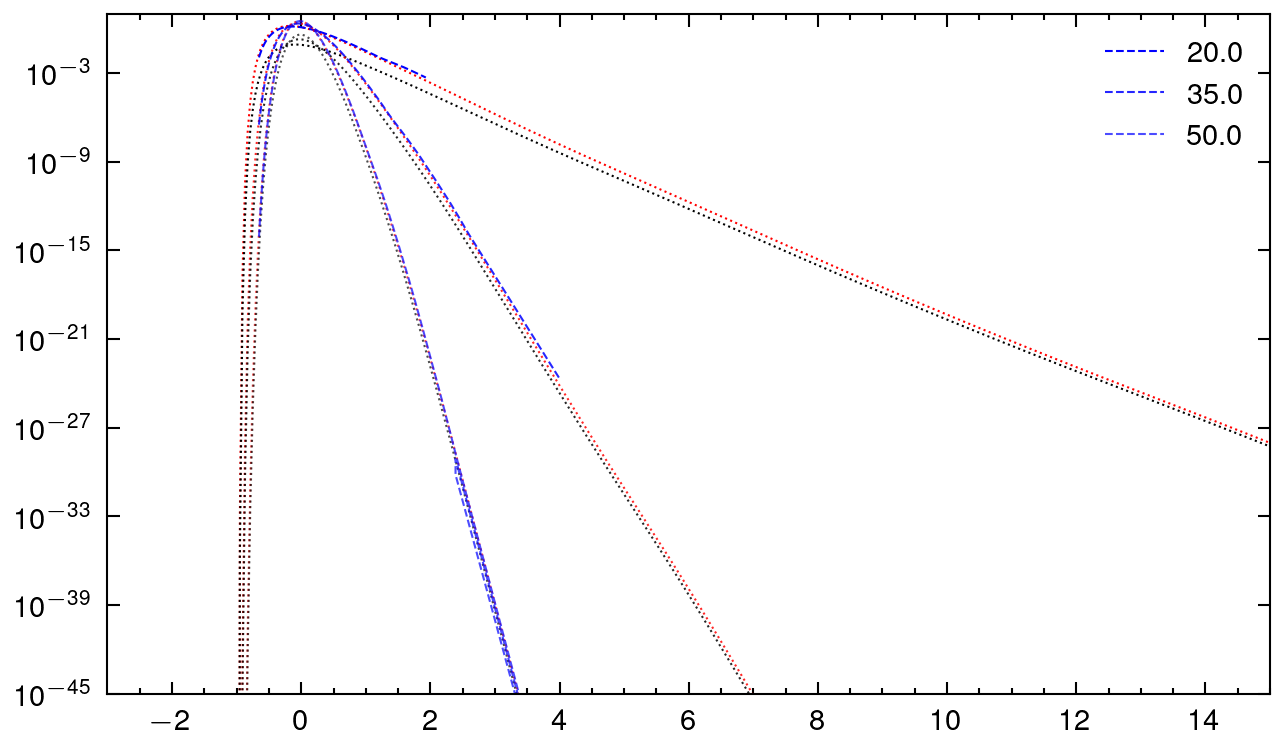

In [29]:
R_range = np.linspace(20,50,num=3)
op = 1

for R in R_range:
    # delta_L, lam, cgf, cgfp, cgfpp, Psi = RCGF_at_the_saddle2(k_l, pk_l, k_nl, pk_nl, R,delta_max=0.9)
    delta_L, lam, cgf, cgfp, cgfpp, Psi_from_legendre = RCGF_at_the_saddle(k_l, pk_l, k_nl, pk_nl, R, delta_max=1.02)
    
    pdf_saddle = np.exp( - lam*cgfp + cgf) / np.sqrt(2 * np.pi * cgfpp)
    
    hdtail = high_density_tail_ValIIB9(del_R,k_l,pk_l,R)
    
    plt.plot(del_R,hdtail,lw=0.5,ls="dotted", alpha = op, c='r')
    plt.plot(del_R,high_dens_b7(del_R,k_l,pk_l,R),lw=0.5,ls="dotted", alpha = op, c='k')
    plt.plot(cgfp,pdf_saddle,   label=str(R), lw= 0.5, ls = "dashed", alpha = op, c = 'b')
    
    op = op - 0.15
plt.yscale("log")
plt.xlim([-3, 15])
plt.ylim([1e-45, 10])
plt.grid
plt.legend()

# Asymptotes a la Bernardeau

Text(0.5, 0, '$\\rho$')

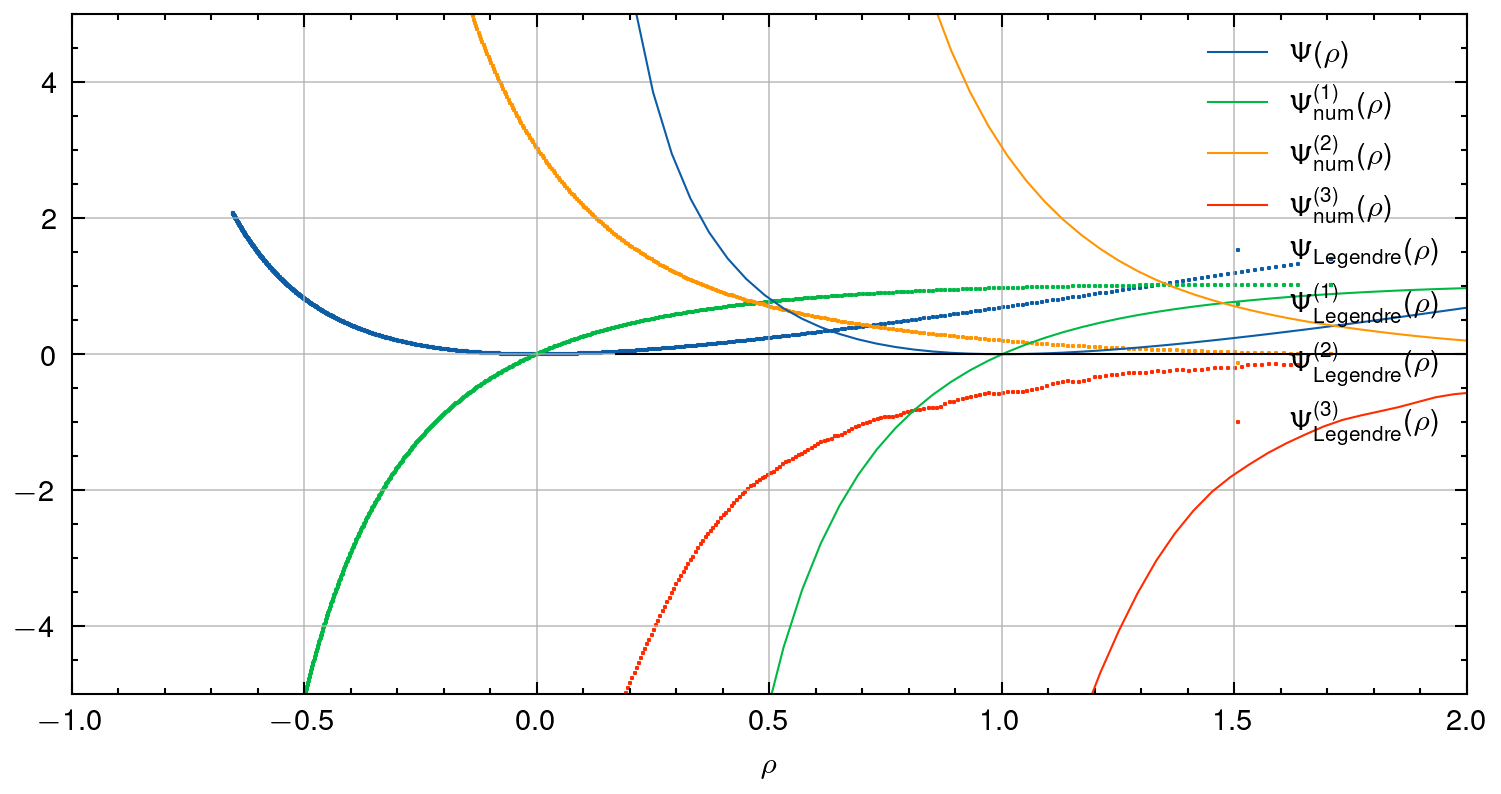

In [20]:
rho_num_deriv,p_num_deriv = characteristic_function_from_definition(del_R, k_l, pk_l, k_nl, pk_nl, R)

plt.plot(rho_num_deriv,p_num_deriv[0,:],lw=0.5, label = r'$\Psi(\rho)$')
plt.plot(rho_num_deriv,p_num_deriv[1,:],lw=0.5, label = r'$\Psi_{\mathrm{num}}^{(1)}(\rho)$')
plt.plot(rho_num_deriv,p_num_deriv[2,:],lw=0.5, label = r'$\Psi_{\mathrm{num}}^{(2)}(\rho)$')
plt.plot(rho_num_deriv,p_num_deriv[3,:],lw=0.5, label = r'$\Psi_{\mathrm{num}}^{(3)}(\rho)$')
# plt.plot(rho_num_deriv,p_num_deriv[4,:],lw=0.5, label = r'$\Psi_{\mathrm{num}}^{(4)}(\rho)$')
# plt.plot(rho_num_deriv,p_num_deriv[5,:],lw=0.5, label = r'$\Psi_{\mathrm{num}}^{(5)}(\rho)$')
plt.plot(rho_num_deriv,[0]*len(rho_num_deriv),c='k',lw=0.5)

plt.scatter(cgfp[::6],Psi_from_legendre[0,::6],lw=0.5, s = .5, marker = 's', label = r'$\Psi_{\mathrm{Legendre}}(\rho)$')
plt.scatter(cgfp[::6],Psi_from_legendre[1,::6],lw=0.5, s = .5, marker = 's', label = r'$\Psi_{\mathrm{Legendre}}^{(1)}(\rho)$')
plt.scatter(cgfp[::6],Psi_from_legendre[2,::6],lw=0.5, s = .5, marker = 's', label = r'$\Psi_{\mathrm{Legendre}}^{(2)}(\rho)$')
plt.scatter(cgfp[::6],Psi_from_legendre[3,::6],lw=0.5, s = .5, marker = 's', label = r'$\Psi_{\mathrm{Legendre}}^{(3)}(\rho)$')

# for i in range(4):
#     plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=i),r_poly),lw=0.5,c='k',alpha = 1/(i+2))

plt.ylim([-5,5])
plt.xlim([-1,2])
plt.grid(alpha=0.8,lw=0.4)
plt.legend()
plt.xlabel(r'$\rho$')

In [21]:
location = np.where((rho_num_deriv<2) & (rho_num_deriv>1))
# print(location)
# print(np.shape(location))
pp = np.polyfit(rho_num_deriv[location], p_num_deriv[2,location][0,:], 5)
np.roots(pp)

array([2.27732179+0.j        , 2.11488344+0.51194051j,
       2.11488344-0.51194051j, 1.31109273+0.70325857j,
       1.31109273-0.70325857j])

In [22]:
rho_c = 1.68285158
lam_c = np.interp(rho_c,rho_num_deriv,p_num_deriv[1,:])
# lam_c = 1.0
print(lam_c)
print(np.interp(lam_c, lam, cgfp))
# cgf_c = np.interp(lam_c, lam, cgf)

pi_3 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[3,:]),dtype=np.complex_)
pi_4 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[4,:]),dtype=np.complex_)
pi_5 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[5,:]),dtype=np.complex_)
pi_6 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[6,:]),dtype=np.complex_)
pi_7 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[7,:]),dtype=np.complex_)

a32 = (2/3) * np.sqrt(2 / pi_3)
a52 = (np.power(1/pi_3, 7/2) * (5*np.square(pi_4) - 3*pi_3*pi_5)) / (45*sqrt(2))
a2  = pi_4 / (6*np.square(pi_3))
a72 = (np.power(1/pi_3,13/2) * ( (385*np.power(pi_4,4)) - (630*pi_3*pi_5*np.power(pi_4,2) + (168*pi_6*pi_4*np.power(pi_3,2) + (3*np.power(pi_3,2)*((35*np.power(pi_5,2)) - (8*pi_3*pi_7))))) )) / (7560*sqrt(2))

r1 = -(np.imag(a52)/np.imag(a32)) - rho_c
r2 = -(7*((2*a2*np.power(a32,2)) + (2*a72*a32) - (np.power(a52,2)))) / (4*np.power(a32,2))

P_1 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv,5/2) )
P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + r1,5/2) )
P_3 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + np.absolute(r1) + (np.absolute(r2)/rho_num_deriv),5/2))

# P_46 = (1/sqrt(2*pi)) * np.sqrt(p_num_deriv[2,:]) * np.exp(- p_num_deriv[0,:])

print("--------------------------------")
print(pi_3)
print(pi_4)
print(pi_5)
print(pi_6)
print(pi_7)
print("--------------------------------")
print(a32)
print(a2)
print(a52)
print(a72)
print("--------------------------------")
print(r1)
print(r2)
print("--------------------------------")
print(P_1)
print(P_2)
print(P_3)
print("--------------------------------")

plt.plot(cgfp,pdf_saddle, lw=0.5, label="Saddle approx.")
plt.plot(rho_num_deriv-1,P_1,label="Bern. LO", lw = 0.5,ls = "dashed")
plt.plot(rho_num_deriv-1,P_2,label="Bern. NLO", lw = 0.5,ls = "dashed")
plt.plot(rho_num_deriv-1,P_3,label="Bern. NNLO", lw = 0.5,ls = "dashed")
# plt.plot(rho_num_deriv-1,P_46,label='Bern. 46',lw=0.5)

plt.plot(CM_delta,       CM_PDF,   label='CM', lw=0.5)
plt.errorbar(del_qui,pdf_qui,
             yerr=std_qui,
             elinewidth = 0.2,
             linewidth = 0.1,
             marker = "s",
             markersize = 0.01,
             capsize = 3,
             capthick = 0.2,
             c = "k",
             label = "Quijote/z=0.5/R=10",
             alpha=0.9)
plt.plot(del_R,hdtail,label="HD tail",lw=0.5)
# plt.plot(del_R,P,lw=0.5,c='r',label='Alt. HD tail')

plt.yscale("log")

# close up
# plt.xlim([-1.5, 5])
# plt.ylim([1e-4, 2])

# Overview
plt.xlim([-1.3, 25])
plt.ylim([1e-20, 2])

# Custom
# plt.xlim([15, 22])
# plt.ylim([1e-12, 1e-8])

plt.legend()

0.873795668165742
0.6818385643371984


NameError: name 'cgf_c' is not defined

In [23]:
# rho_c = 0.43170593 # graphically too # raising this raises the tail
# lam_c = np.interp(rho_c,r,p[1,:])
# print(lam_c)
# print(np.interp(lam_c, lam, cgfp))
# cgf_c = np.interp(lam_c, lam, cgf)

# pi_3 = np.array(np.interp(rho_c, r, p[3,:]),dtype=np.complex_)
# pi_4 = np.array(np.interp(rho_c, r, p[4,:]),dtype=np.complex_)
# pi_5 = np.array(np.interp(rho_c, r, p[5,:]),dtype=np.complex_)
# pi_6 = np.array(np.interp(rho_c, r, p[6,:]),dtype=np.complex_)
# pi_7 = np.array(np.interp(rho_c, r, p[7,:]),dtype=np.complex_)

# a32 = (2/3) * np.sqrt(2 / pi_3)
# a52 = (np.power(1/pi_3, 7/2) * (5*np.square(pi_4) - 3*pi_3*pi_5)) / (45*sqrt(2))
# a2  = pi_4 / (6*np.square(pi_3))
# a72 = (np.power(1/pi_3,13/2) * ( (385*np.power(pi_4,4)) - (630*pi_3*pi_5*np.power(pi_4,2) + (168*pi_6*pi_4*np.power(pi_3,2) + (3*np.power(pi_3,2)*((35*np.power(pi_5,2)) - (8*pi_3*pi_7))))) )) / (7560*sqrt(2))

# r1 = -(np.imag(a52)/np.imag(a32)) - rho_c
# r2 = -(7*((2*a2*np.power(a32,2)) + (2*a72*a32) - (np.power(a52,2)))) / (4*np.power(a32,2))

# P_1 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*r) ) / (4*np.sqrt(pi)*np.power(r + 0,5/2))
# P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*r) ) / (4*np.sqrt(pi)*np.power(r + r1,5/2))
# P_3 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*r) ) / (4*np.sqrt(pi)*np.power(r + np.absolute(r1) + (np.absolute(r2)/r),5/2))

# print("--------------------------------")
# print(pi_3)
# print(pi_4)
# print(pi_5)
# print(pi_6)
# print(pi_7)
# print("--------------------------------")
# print(a32)
# print(a2)
# print(a52)
# print(a72)
# print("--------------------------------")
# print(r1)
# print(r2)
# print("--------------------------------")
# print(P_1)
# print(P_2)
# print(P_3)
# print("--------------------------------")

In [24]:
cgf_ber = cgf_c + (lam - lam_c)*rho_c + np.absolute(a32)*np.power(lam - lam_c,3/2)

NameError: name 'cgf_c' is not defined

In [ ]:
plt.plot(lam,cgf_ber)
# plt.plot(lam,cgf)
# plt.xlim([-4,3])
plt.xlim([0.9,1.1])
# plt.ylim([-1,2])
# plt.ylim([0,0.3])

In [19]:
new_lam = np.linspace(0.5,1.5,num=100)
cgf_ber = cgf_c + (new_lam - lam_c)*rho_c + np.sqrt((a32*np.power(new_lam - lam_c,3)))

plt.plot(new_lam,cgf_ber)
plt.plot(lam_new,cgf_new,linestyle='dashed')
plt.xlim([-4,3])
# plt.xlim([1.022,1.026])
plt.ylim([-1,1])
# plt.ylim([0.34,0.36])

NameError: name 'cgf_c' is not defined

In [63]:
cgf_ber = cgf_c + (lam - lam_c)*rho_c + np.absolute(a32)*np.power(lam - lam_c,3/2)

/scratch-local/slurm-job-tmp-3395712/ipykernel_812/2128115577.py:1: RuntimeWarning: invalid value encountered in power
  cgf_ber = cgf_c + (lam - lam_c)*rho_c + np.absolute(a32)*np.power(lam - lam_c,3/2)


In [64]:
i_max = np.argmax(lam)
i_max -= 1
lam_new = lam[:i_max]
cgf_new = cgf[:i_max]
cgf_c = np.interp(lam_c, lam_new, cgf_new)

In [65]:
cgf_c

0.3493604655380284

# Asymptotes a la Bernardeau (2)

In [166]:
rho_num_deriv,p_num_deriv = characteristic_function_from_definition(del_R, k_l, pk_l, k_nl, pk_nl, R)

In [167]:
i_max = np.argmax(lam)
i_max -= 1
lam_new = lam[:i_max]
lam_c = lam_new[-1]
print(lam_c)

cgf_new = cgf[:i_max]
cgf_new = cgf_new + lam_new
cgf_c = np.interp(lam_c, lam_new, cgf_new)
print(cgf_c)

1.0238992148732824
1.3730705452155156


In [168]:
location = np.where((rho_num_deriv<2) & (rho_num_deriv>1))
# print(location)
# print(np.shape(location))
pp = np.polyfit(rho_num_deriv[location], p_num_deriv[2,location][0,:], 5)
np.roots(pp)

array([2.27732179+0.j        , 2.11488344+0.51194051j,
       2.11488344-0.51194051j, 1.31109273+0.70325857j,
       1.31109273-0.70325857j])

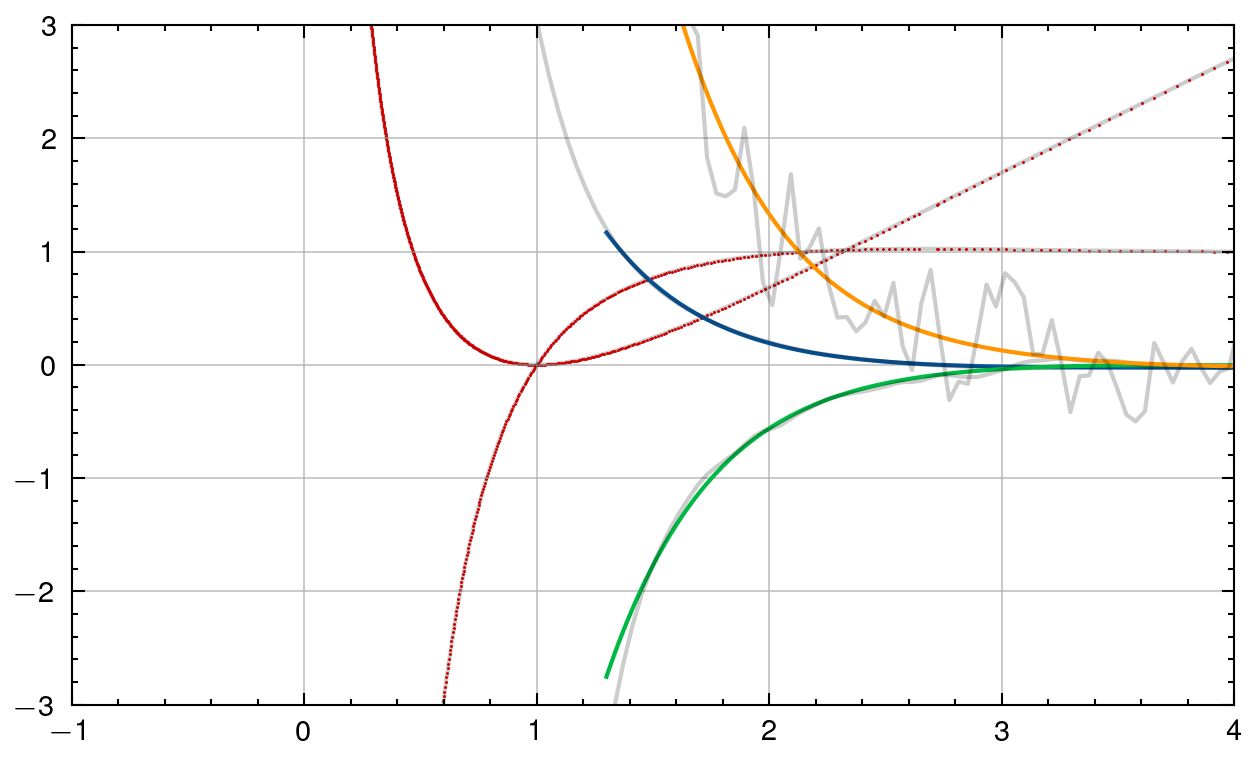

In [170]:
# Keep fiddling with the rank and the range over which r_poly is defined until you reach clean derivatives that have no oscillations 
# and that follow the numerical ones on lower orders

rank = 23
r_poly = np.linspace(0.3,20,2**12)


rank = 15
r_poly = np.linspace(1.3,20,2**10)


psi0_poly = np.polyfit(r_poly, np.interp(r_poly,rho_num_deriv,p_num_deriv[2,:]), rank)

plt.plot(rho_num_deriv,p_num_deriv[0,:],alpha=0.2,c='k',lw=1)
plt.plot(rho_num_deriv,p_num_deriv[1,:],alpha=0.2,c='k',lw=1)

plt.scatter(cgfp[1:-1]+1,Psi_from_legendre[0,:],lw=0, s = 0.5, c='r', label = r'$\Psi^{(0)}(\rho)$')
plt.scatter(cgfp[1:-1]+1,Psi_from_legendre[1,:],lw=0, s = 0.5, c='r', label = r'$\Psi^{(0)}(\rho)$')

for i in range(3):
    plt.plot(r_poly,np.polyval(np.polyder(psi0_poly,m=i),r_poly))
    plt.plot(rho_num_deriv,p_num_deriv[i+2,:],alpha=0.2,c='k',lw=1)
plt.ylim([-3,3])
plt.xlim([-1,4])
# plt.xlim([1,2])
plt.grid(alpha=0.8,lw=0.4)
# plt.legend()

In [171]:
rho_c = 2.29044684
# lam_c = np.interp(rho_c,rho_num_deriv,p_num_deriv[1,:])
# print(lam_c)
print(np.interp(lam_c, lam, cgfp))

# pi_3 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[3,:]),dtype=np.complex_)
# pi_4 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[4,:]),dtype=np.complex_)
# pi_5 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[5,:]),dtype=np.complex_)
# pi_6 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[6,:]),dtype=np.complex_)
# pi_7 = np.array(np.interp(rho_c, rho_num_deriv, p_num_deriv[7,:]),dtype=np.complex_)


pi_3 = np.array(np.polyval(np.polyder(psi0_poly,m=1+0),rho_c),dtype=np.complex_)
pi_4 = np.array(np.polyval(np.polyder(psi0_poly,m=2+0),rho_c),dtype=np.complex_)
pi_5 = np.array(np.polyval(np.polyder(psi0_poly,m=3+0),rho_c),dtype=np.complex_)
pi_6 = np.array(np.polyval(np.polyder(psi0_poly,m=4+0),rho_c),dtype=np.complex_)
pi_7 = np.array(np.polyval(np.polyder(psi0_poly,m=5+0),rho_c),dtype=np.complex_)


a32 = (2/3) * np.sqrt(2 / pi_3)
a52 = (np.power(1/pi_3, 7/2) * (5*np.square(pi_4) - 3*pi_3*pi_5)) / (45*sqrt(2))
a2  = -pi_4 / (6*np.square(pi_3))
a72 = (np.power(1/pi_3,13/2) * ( (385*np.power(pi_4,4)) - (630*pi_3*pi_5*np.power(pi_4,2) + (168*pi_6*pi_4*np.power(pi_3,2) + (3*np.power(pi_3,2)*((35*np.power(pi_5,2)) - (8*pi_3*pi_7))))) )) / (7560*sqrt(2))

r1 = -(np.imag(a52)/np.imag(a32)) - rho_c
r2 = -(7*((2*a2*np.power(a32,2)) + (2*a72*a32) - (np.power(a52,2)))) / (4*np.power(a32,2))

P_1 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv,5/2) )
P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + r1,5/2) )
P_3 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + np.absolute(r1) + (np.absolute(r2)/rho_num_deriv),5/2))

# P_1 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*del_R) ) / ( 4 * np.sqrt(pi) * np.power(del_R,5/2) )
# P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*del_R) ) / ( 4 * np.sqrt(pi) * np.power(del_R + r1,5/2) )
# P_3 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*del_R) ) / ( 4 * np.sqrt(pi) * np.power(del_R + np.absolute(r1) + (np.absolute(r2)/del_R),5/2))

P_46 = (1/sqrt(2*pi)) * np.sqrt(p_num_deriv[2,:]) * np.exp(- p_num_deriv[0,:])

P_47_1 = np.exp(cgf_c - lam_c*rho_num_deriv) * ( (3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv - rho_c,5/2)))
P_47_2 = np.exp(cgf_c - lam_c*rho_num_deriv) * ( ((3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv - rho_c,5/2))) + ((15*np.imag(a52))/(8 * np.sqrt(pi) * np.power(rho_num_deriv - rho_c,7/2))))

# P_47_1 = np.exp(cgf_c - lam_c*del_R) * ( (3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(del_R - rho_c,5/2)))
# P_47_2 = np.exp(cgf_c - lam_c*del_R) * ( ((3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(del_R - rho_c,5/2))) + ((15*np.imag(a52))/(8 * np.sqrt(pi) * np.power(del_R - rho_c,7/2))))

print("--------------------------------")
print(pi_3)
print(pi_4)
print(pi_5)
print(pi_6)
print(pi_7)
print("--------------------------------")
print(a32)
print(a2)
print(a52)
print(a72)
print("--------------------------------")
print(r1)
print(r2)
print("--------------------------------")
print(P_1)
print(P_2)
print(P_3)
print("--------------------------------")

7.555634426787421
--------------------------------
(-0.2783822193857901+0j)
(0.6915708129130138+0j)
(-1.5728878981153684+0j)
(3.4696190331237347+0j)
(-7.503518995882217+0j)
--------------------------------
-1.7869112881053049j
(-1.487313157080857+0j)
(-6.377166660484613e-16+1.4878147875370258j)
(3.411080079389252e-14+34.79499496252185j)
--------------------------------
-1.4578286806986598
(74.57129484581502-6.577237095804498e-14j)
--------------------------------
[2.09566116e+02 1.18592432e+02 7.36077742e+01 ... 2.11159735e-22
 2.02174757e-22 1.93572561e-22]
[           nan            nan            nan ... 2.31289326e-22
 2.21427655e-22 2.11987014e-22]
[6.18872208e-07 1.00499127e-06 1.48780963e-06 ... 1.73938536e-22
 1.66584835e-22 1.59542299e-22]
--------------------------------


/scratch-local/slurm-job-tmp-4049409/ipykernel_58/3566424245.py:29: RuntimeWarning: invalid value encountered in power
  P_2 = (3 * np.absolute(a32) * np.exp(cgf_c - lam_c*rho_num_deriv) ) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv + r1,5/2) )
/scratch-local/slurm-job-tmp-4049409/ipykernel_58/3566424245.py:36: RuntimeWarning: invalid value encountered in sqrt
  P_46 = (1/sqrt(2*pi)) * np.sqrt(p_num_deriv[2,:]) * np.exp(- p_num_deriv[0,:])
/scratch-local/slurm-job-tmp-4049409/ipykernel_58/3566424245.py:38: RuntimeWarning: invalid value encountered in power
  P_47_1 = np.exp(cgf_c - lam_c*rho_num_deriv) * ( (3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv - rho_c,5/2)))
/scratch-local/slurm-job-tmp-4049409/ipykernel_58/3566424245.py:39: RuntimeWarning: invalid value encountered in power
  P_47_2 = np.exp(cgf_c - lam_c*rho_num_deriv) * ( ((3*np.imag(a32)) / ( 4 * np.sqrt(pi) * np.power(rho_num_deriv - rho_c,5/2))) + ((15*np.imag(a52))/(8 * np.sqrt(pi) * np.power(rho_num_der

In [172]:
# new_lam = np.linspace(0.5,1.5,num=100)
# cgf_ber = cgf_c + (new_lam - lam_c)*rho_c + a32*np.power(new_lam - lam_c,3/2) - a2*np.square(new_lam - lam_c) + a52*np.power((new_lam - lam_c),5/2)

# plt.plot(new_lam,np.real(cgf_ber))
# plt.plot(lam_new,cgf_new,linestyle='dashed')
# plt.plot(new_lam,np.imag(cgf_ber))
# plt.xlim([-4,3])
# # plt.xlim([1.022,1.026])
# plt.ylim([-1,1])
# # plt.ylim([0.34,0.36])

In [173]:
# # plt.plot(new_lam,np.real(np.sqrt(np.square(a32)*np.power(new_lam - lam_c,3))))
# # plt.plot(new_lam,np.imag(a32*np.sqrt(np.power(new_lam - lam_c,3))))
# # plt.xlim([-4,3])
# # # plt.xlim([1.022,1.026])
# # plt.ylim([-1,1])
# # # plt.ylim([0.34,0.36])
# plt.semilogy(rho_num_deriv, -P_47_1)
# plt.semilogy(rho_num_deriv, P_47_2)

ValueError: x and y must have same first dimension, but have shapes (1020,) and (16380,)

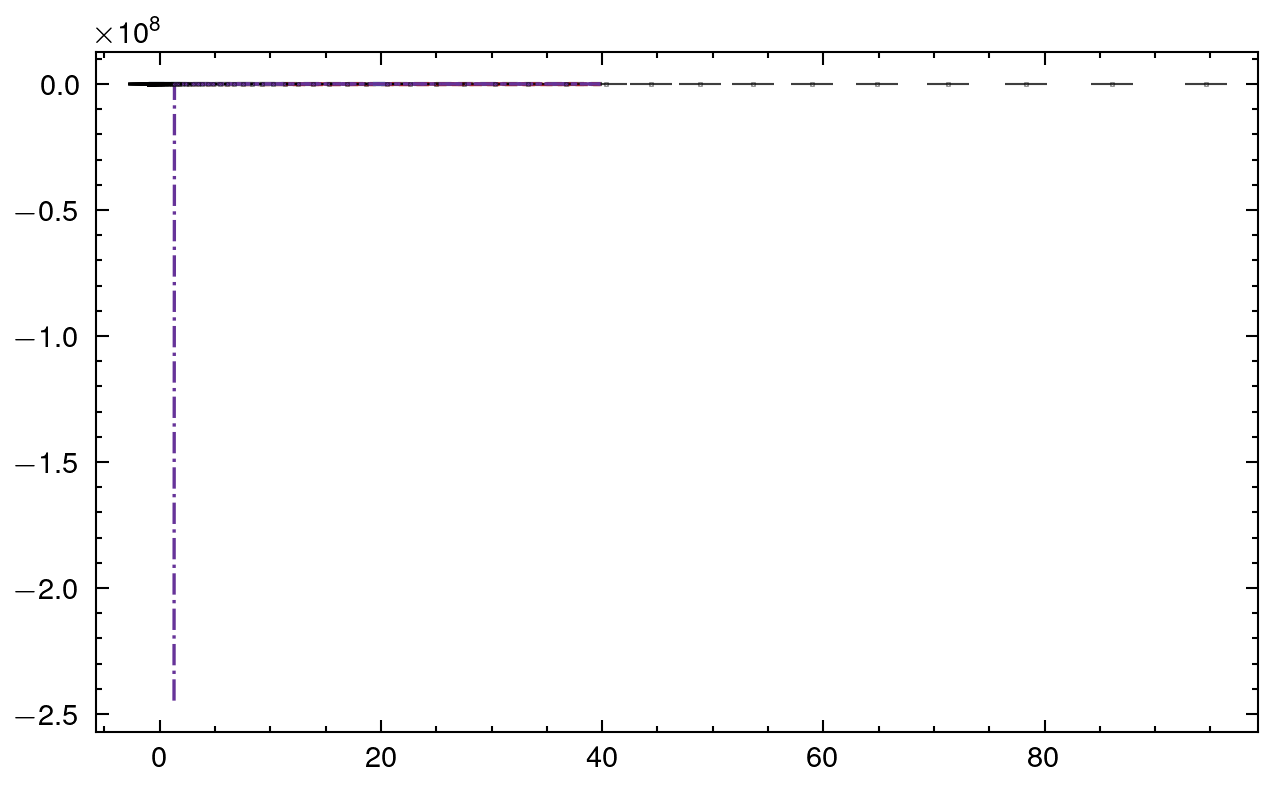

In [174]:
del_normal,p_normal = normal_distribution(del_R,sigma_from_power_spectrum(k_l, pk_l, R),1)
plt.plot(del_normal,p_normal,label=r'$\mathcal{N}(1,\sigma_{L,R}^2)$',c='k',ls='--',alpha=0.6)

plt.plot(rho_num_deriv-1,P_1,c='firebrick',label="Asymp. LO", ls = "dotted", lw=0.8)
plt.plot(rho_num_deriv-1,P_2,c='firebrick',label="Asymp. NLO", ls = "dashdot", lw=0.8)
plt.plot(rho_num_deriv-1,P_3,c='firebrick',label="Asymp. NNLO", ls = "dashed", lw=0.8)

plt.plot(rho_num_deriv-1,P_46,c='steelblue',label='Saddle-Point Approx')
plt.plot(CM_delta,CM_PDF,c='grey',label='CosMomentum')
plt.errorbar(del_qui,pdf_qui,yerr=std_qui,elinewidth = 0.5,linewidth = 0.0,marker = "s",markersize = 0.1,capsize = 5,capthick = 0.5,c = "k",label = r"Quijote/$15000$ reals./$N=512^3$",alpha=0.5)
# indx = int(np.where(del_R>2)[0][0])
# plt.plot(del_R,hdtail,label="HD Tail B.9")
# plt.plot(del_R[indx:-1],Pp[indx:-1],c='yellowgreen',label = 'High Den. Tail') # b.7
# plt.plot(del_R,Pp,c='yellowgreen',label = 'High Den. Tail') # b.7

plt.plot(rho_num_deriv-1,-P_47_1,c='rebeccapurple',label="Asymp. LO", ls = "dotted", lw=0.8)
plt.plot(rho_num_deriv-1,-P_47_2,c='rebeccapurple',label="Asymp. NLO", ls = "dashdot", lw=0.8)

plt.plot(cgfp,pdf_saddle,label="Saddle approx.")

plt.yscale("log")

# close up
# plt.xlim([-1.5, 5])
# plt.ylim([1e-4, 2])

# Overview
# plt.xlim([-1.3, 25])
# plt.ylim([1e-20, 2])

# Custom
plt.xlim([-2,25])
plt.ylim([1e-12, 3])

plt.legend()
plt.grid(lw=0.5,alpha=0.5)
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathcal{P}(\delta_R)$')
plt.savefig("pdf.pdf")

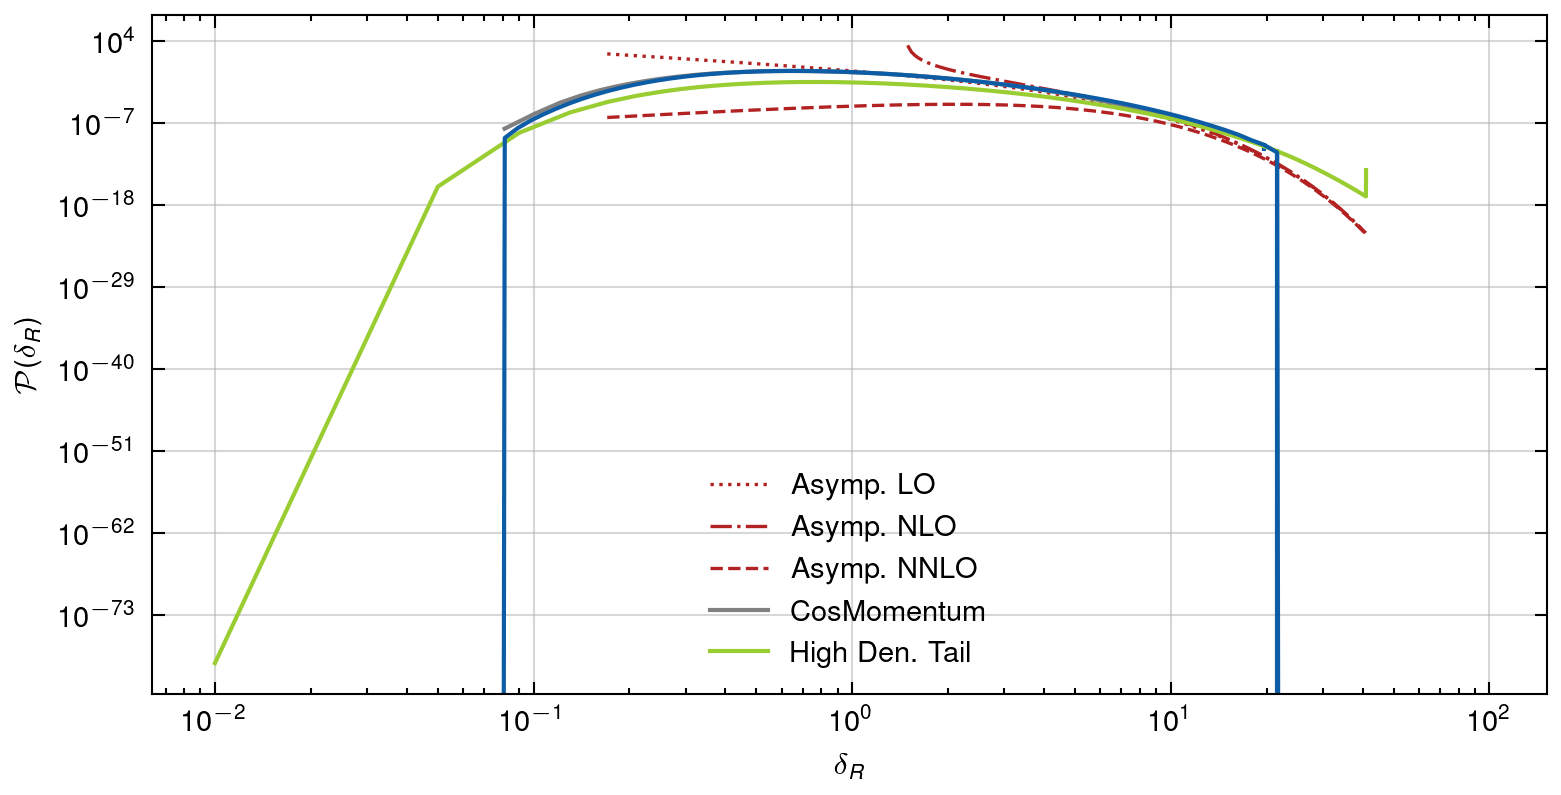

In [30]:
plt.plot(rho_num_deriv,P_1,c='firebrick',label="Asymp. LO", ls = "dotted", lw=0.8)
plt.plot(rho_num_deriv,P_2,c='firebrick',label="Asymp. NLO", ls = "dashdot", lw=0.8)
plt.plot(rho_num_deriv,P_3,c='firebrick',label="Asymp. NNLO", ls = "dashed", lw=0.8)

# plt.plot(rho_num_deriv,P_46,c='steelblue',label='Saddle-Point Approx')
plt.plot(CM_delta+1,CM_PDF,c='grey',label='CosMomentum')
# plt.errorbar(del_qui+1,pdf_qui,yerr=std_qui,elinewidth = 0.5,linewidth = 0.0,marker = "s",markersize = 0.1,capsize = 5,capthick = 0.5,c = "k",label = r"Quijote/$15000$ reals./$N=512^3$",alpha=0.5)
plt.errorbar(del_qui+1,pdf_qui,yerr=std_qui)
# indx = int(np.where(del_R>2)[0][0])
# plt.plot(del_R,hdtail,label="HD Tail B.9")
# plt.plot(del_R[indx:-1],Pp[indx:-1],c='yellowgreen',label = 'High Den. Tail') # b.7
plt.plot(del_R+1,Pp,c='yellowgreen',label = 'High Den. Tail') # b.7

# plt.plot(rho_num_deriv,-P_47_1,c='rebeccapurple',label="Asymp. LO", ls = "dotted", lw=0.8)
# plt.plot(rho_num_deriv,-P_47_2,c='rebeccapurple',label="Asymp. NLO", ls = "dashdot", lw=0.8)

# plt.plot(cgfp+1,pdf_saddle,label="Saddle approx.")

plt.yscale("log")
plt.xscale("log")

# close up
# plt.xlim([-1.5, 5])
# plt.ylim([1e-4, 2])

# Overview
# plt.xlim([-1.3, 25])
# plt.ylim([1e-20, 2])

# Custom
# plt.xlim([7e0,5e1])
# plt.ylim([1e-16, 1e-3])

plt.legend()
plt.grid(lw=0.5,alpha=0.5)
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathcal{P}(\delta_R)$')
plt.savefig("pdf.pdf")

# Plotting Full CGFs from polynomials

In [33]:
from astropy.io import fits

In [34]:
# HR4

# Loading and transforming HR4 sims at z=0.7
dens = fits.open('/project/ls-gruen/users/jamal.elkuweiss/Data/HR4_R10_z0.fits')
dens = dens[0].data
# fdens = np.reshape(dens, [1, np.prod(dens.shape)])
HR4 = np.histogram(dens, density=True, bins = 100)
HR4_delta = np.array([(HR4[1][i+1]-HR4[1][i])/2 + (HR4[1][i]) for i in range(len(HR4[1])-1)])
HR4_pdf = HR4[0]
# del dens,HR4#,fdens
dens.shape

(252, 252, 252)

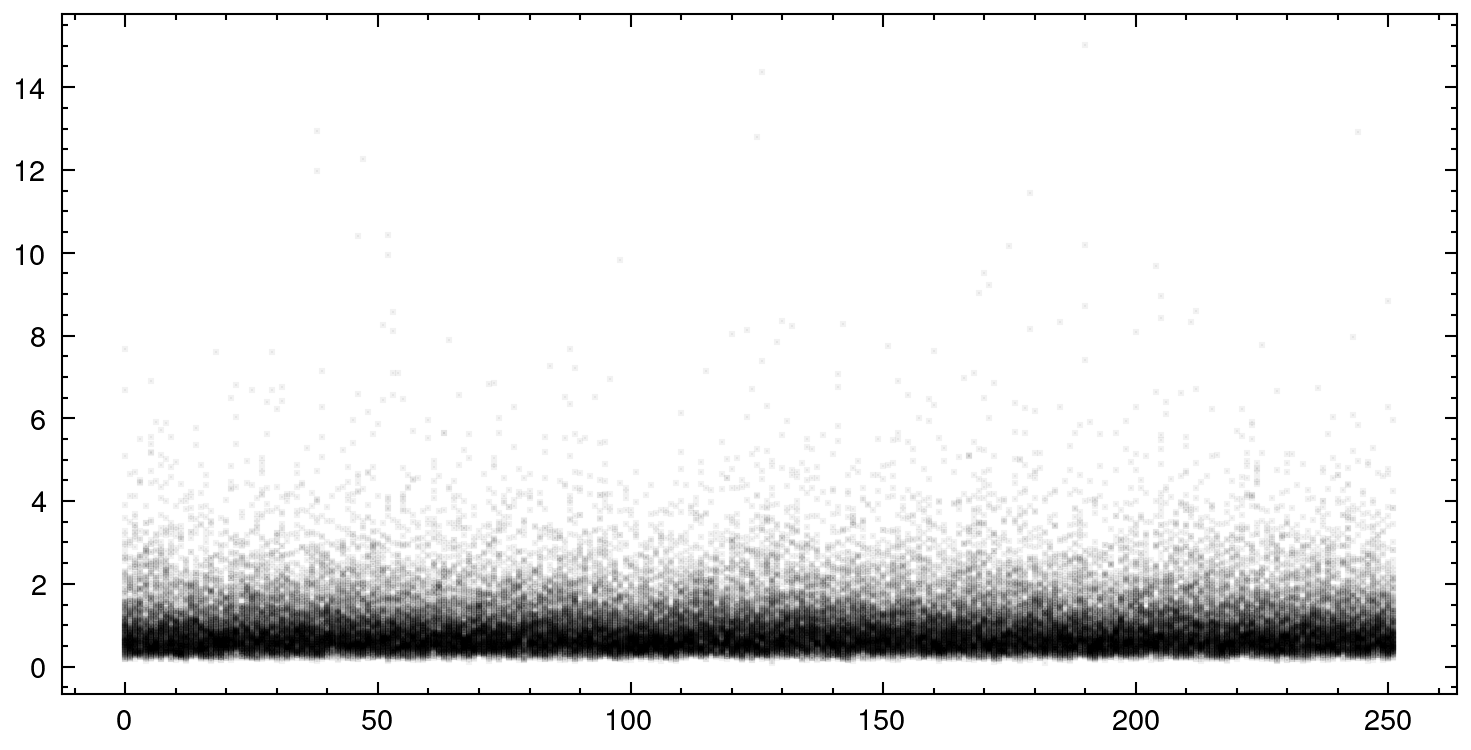

In [44]:
# plt.plot(dens[1,1,:])
for i in range(252):
    # op = 1/(i+1)
    op = 0.05
    plt.plot(dens[i,1,:],alpha = op,c='k',lw=0,marker='s',markersize=0.5)

# Many Redshift/radius plots

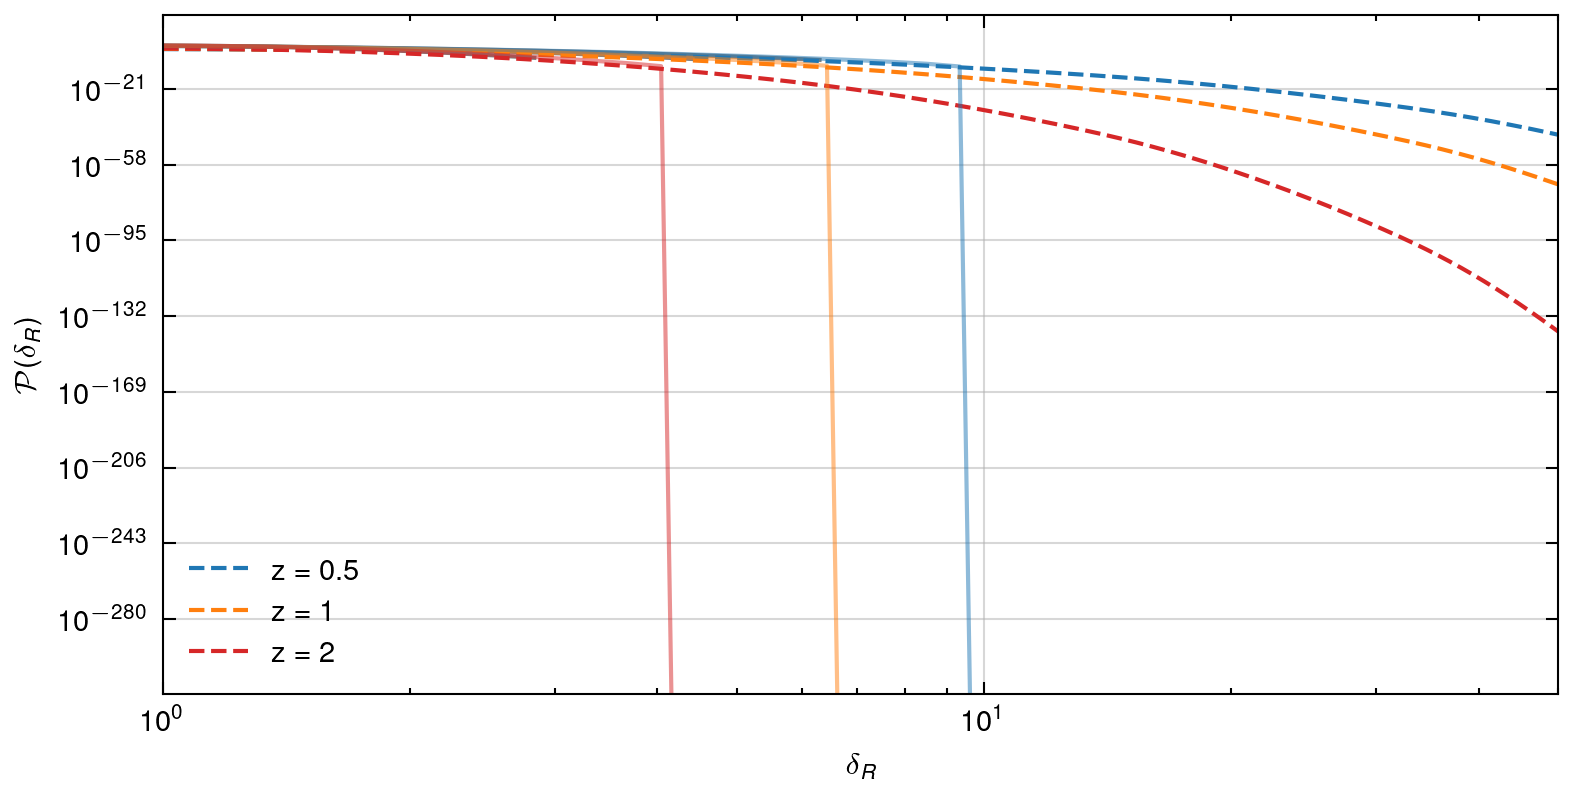

In [39]:
# Those are all the ones available now, to get more, go back and pre-calculate from cosmomentum and extract from Quijote, this range should be enough though
z_array = [0.5,1,2]
R_array = [15.0]

color_list = ['tab:blue','tab:orange','tab:red','tab:green','tab:purple','tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan']
c_ind = 0

for R in R_array:
    # print(R)
    for z in z_array:
        # print(z)
        quijote_pathname = "/project/ls-gruen/users/jamal.elkuweiss/Data/Quijote_PDFs_15000_512CDMparticles/quijote_PDF_z" + str(z) +"_R" + str(R) +".npy"
        del_qui, pdf_qui, std_qui = load_quijote_sim(quijote_pathname)
        plt.errorbar(del_qui+1,pdf_qui,yerr=std_qui,alpha = 0.5,c=color_list[c_ind])
        
        
        CM_delta = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/CosMom/delta_quijote_z" + str(z) +"_R" + str(int(R)) +"_CosMom.npy")
        CM_PDF = np.load("/project/ls-gruen/users/jamal.elkuweiss/Data/CosMom/PDF_quijote_z" + str(z) +"_R" + str(int(R)) +"_CosMom.npy")
        plt.plot(CM_delta+1,CM_PDF,c='grey')
        
        
        k_l,pk_l,k_nl,pk_nl = np.load("power_spectra_kl_pl_knl_pnl_z="+ str(z)+".npy")
        del_R = np.linspace(0,120,num=2**12)
        plt.plot(del_R+1,high_dens_b7(del_R,k_l,pk_l,R),ls='dashed',c=color_list[c_ind],label="z = " + str(z))
        
        c_ind += 1
plt.yscale("log")
plt.xscale("log")
plt.xlim([1,50])
# plt.ylim([1e-30, 5])
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathcal{P}(\delta_R)$')
plt.legend()
plt.grid(lw=0.5,alpha=0.5)
# plt.title("PDF for R = 10.0 Mpc, for three redshifts, Solid lines - CosMomentum, Dotted lines - Quijote, Dashed lines - HD tails")
plt.show()

# Tests

### Collapse

In [12]:
def collapz():
    sinhp0 = np.sinh(p0)
    coshp0 = np.cosh(p0)
    
    emin = (9/2)*(sinhp0*(sinhp0 - p0))/np.square(coshp0 - 1)
    print(emin)
    t = np.linspace(0,2*np.pi)
    NL = np.power((coshp0 - 1)/(1 - np.cos(t)),3)*np.square((t - np.sin(t))/(sinhp0 - p0)) - 1
    L = emin*(np.power((t - np.sin(t))/(sinhp0 - p0),2/3) + 1)
    
    return L,NL

def collapzEDS():
    t = np.linspace(0,2*np.pi,num=2**10)
    NL = ((9/2)*np.square(t - np.sin(t))/np.power(1-np.cos(t),3)) - 1
    L = (3/5)*np.power(((3/4)*(t - np.sin(t))),2/3)
    return L,NL

def collapz():
    t = np.linspace(0,2*np.pi,num=2**10)
    NL = ((9/2)*np.square(t - np.sin(t))/np.power(1-np.cos(t),3)) - 1
    L = (3/5)*np.power(((3/4)*(t - np.sin(t))),2/3)
    return L,NL

In [13]:
one,two = collapzEDS()

/scratch-local/slurm-job-tmp-3877219/ipykernel_88/1936518938.py:15: RuntimeWarning: divide by zero encountered in true_divide
  NL = ((9/2)*np.square(t - np.sin(t))/np.power(1-np.cos(t),3)) - 1
/scratch-local/slurm-job-tmp-3877219/ipykernel_88/1936518938.py:15: RuntimeWarning: invalid value encountered in true_divide
  NL = ((9/2)*np.square(t - np.sin(t))/np.power(1-np.cos(t),3)) - 1


/scratch-local/slurm-job-tmp-3877219/ipykernel_88/3788251414.py:2: RuntimeWarning: invalid value encountered in power
  plt.plot(one, 1/np.power(1 - (2*one/3),3/2)-1)
/home/j/J.Kuweiss/High-density-tails-of-Delta/functions.py:13: RuntimeWarning: invalid value encountered in power
  return np.power((1 - delta / nu), -nu) - 1


(0.0, 1000.0)

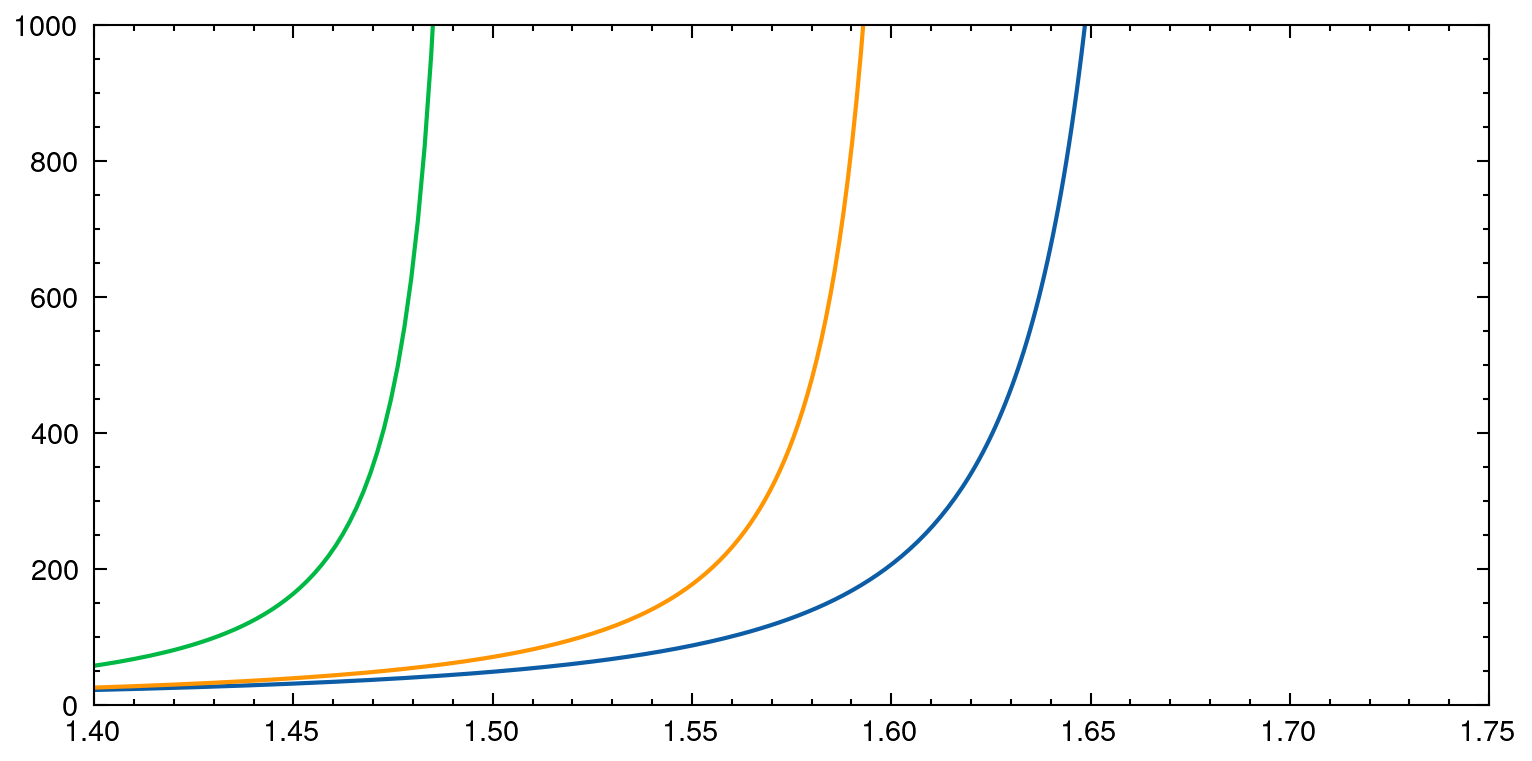

In [18]:
plt.plot(one,two)
plt.plot(one, 1/np.power(1 - (2*one/3),3/2)-1)
plt.plot(one,approximate_collapse_alex(one))
plt.xlim([1.4,1.75])
plt.ylim([0,1000])

### Random Plotting

Text(0, 0.5, '$\\mathcal{C}(\\lambda)$')

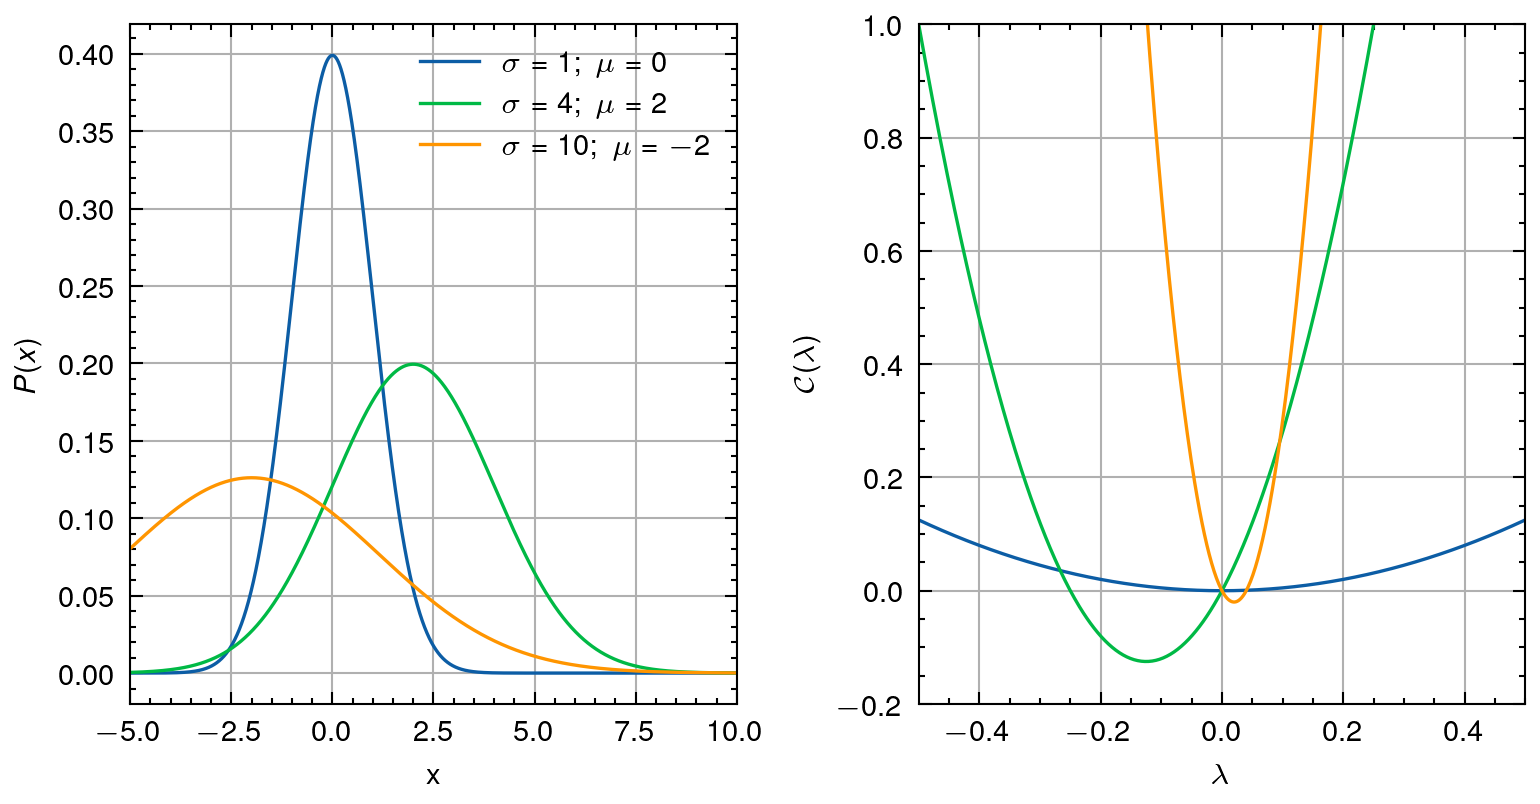

In [20]:
# Normal distribution with CGFs

x = np.linspace(-10,10,10000)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
fig.subplots_adjust(wspace=0.3)
ax.shape

del_normal,p_normal = normal_distribution(x,1,0)
ax[0].plot(del_normal,p_normal,label=r'$\sigma = 1; \ \mu = 0$',c=colors[0])
ax[1].plot(x,0.5*(1)*np.square(x),label=r'$\sigma = 3; \ \mu = 0$',c=colors[0])

del_normal,p_normal = normal_distribution(x,4,2)
ax[0].plot(del_normal,p_normal,label=r'$\sigma = 4; \ \mu = 2$',c=colors[1])
ax[1].plot(x,(2*x) + 0.5*16*np.square(x),label=r'$\sigma = 4; \ \mu = 1$',c=colors[1])

del_normal,p_normal = normal_distribution(x,10,-2)
ax[0].plot(del_normal,p_normal,label=r'$\sigma = 10; \ \mu = -2$',c=colors[2])
ax[1].plot(x,(-2*x) + 0.5*100*np.square(x),label=r'$\sigma = 5; \ \mu = 2$',c=colors[2])

ax[0].grid()
ax[1].grid()
ax[0].legend()

ax[0].set_xlim([-5, 10])
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([-0.2, 1])

ax[0].set_xlabel("x")
ax[1].set_xlabel("$\lambda$")

ax[0].set_ylabel("$P(x)$")
ax[1].set_ylabel("$\mathcal{C}(\lambda)$")

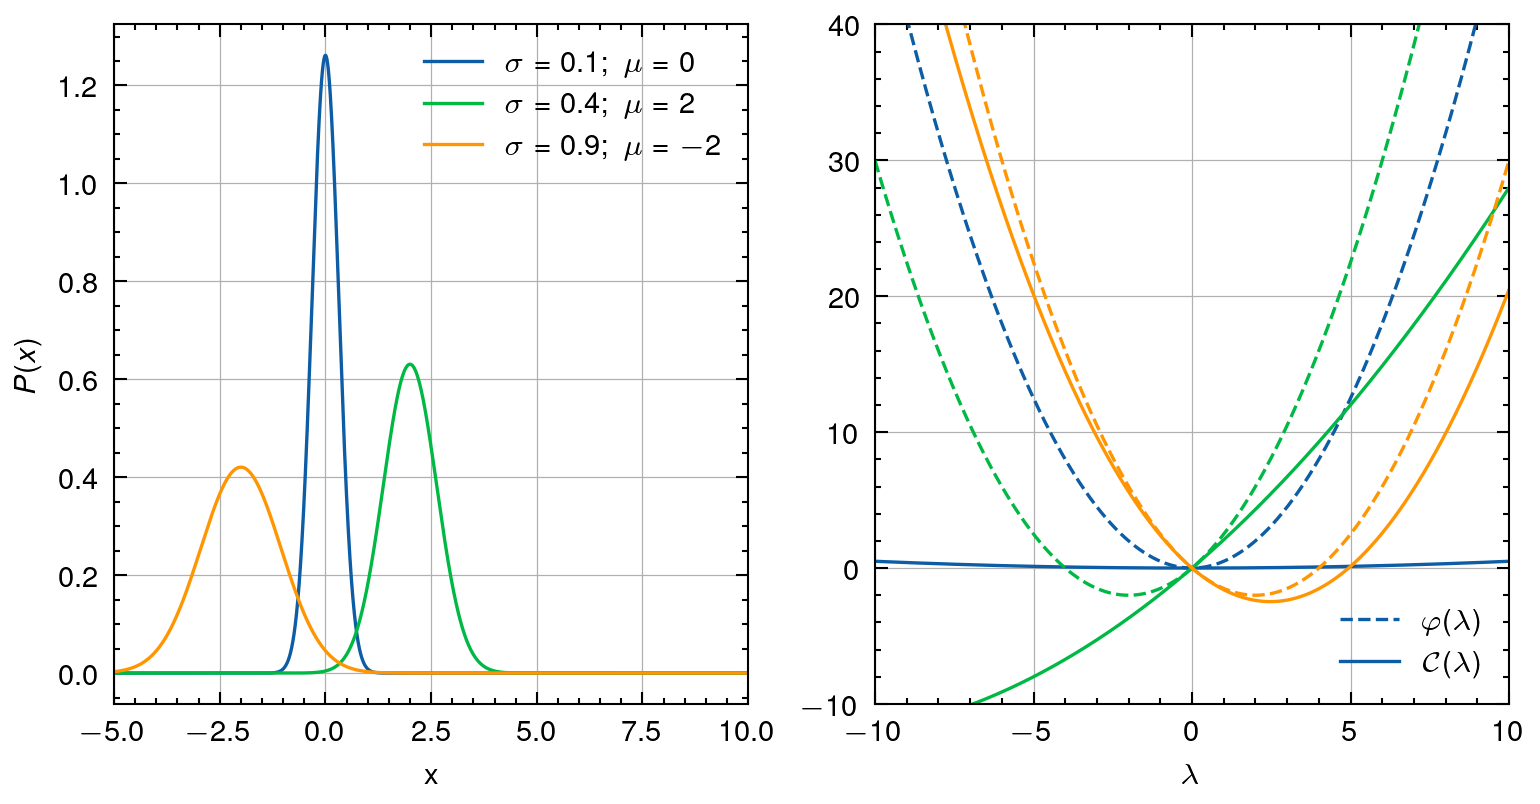

In [23]:
# Normal distribution with RCGFs

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
fig.subplots_adjust(wspace=0.2)
ax.shape

del_normal,p_normal = normal_distribution(x,0.1,0)
ax[0].plot(del_normal,p_normal,label=r'$\sigma = 0.1; \ \mu = 0$',c=colors[0],lw=.8)
ax[1].plot(x,0.5*np.square(x),c=colors[0],linestyle='dashed',lw=.8, label=r'$\varphi(\lambda)$')
ax[1].plot(x,0.5*(0.01)*np.square(x),c=colors[0],lw=.8, label=r'$\mathcal{C}(\lambda)$')

del_normal,p_normal = normal_distribution(x,0.4,2)
ax[0].plot(del_normal,p_normal,label=r'$\sigma = 0.4; \ \mu = 2$',c=colors[1],lw=.8)
ax[1].plot(x,(2*x) + 0.5*np.square(x),c=colors[1],linestyle='dashed',lw=.8)
ax[1].plot(x,(2*x) + 0.5*0.16*np.square(x),c=colors[1],lw=.8)

del_normal,p_normal = normal_distribution(x,0.9,-2)
ax[0].plot(del_normal,p_normal,label=r'$\sigma = 0.9; \ \mu = -2$',c=colors[2],lw=.8)
ax[1].plot(x,(-2*x) + 0.5*np.square(x),c=colors[2],linestyle='dashed',lw=.8)
ax[1].plot(x,(-2*x) + 0.5*(0.9**2)*np.square(x),c=colors[2],lw=.8)

ax[0].grid(lw=0.3)
ax[1].grid(lw=0.3)
ax[0].legend()
ax[1].legend()

ax[0].set_xlim([-5, 10])
ax[1].set_xlim([-10, 10])
ax[1].set_ylim([-10, 40])

ax[0].set_xlabel("x")
ax[1].set_xlabel("$\lambda$")

ax[0].set_ylabel("$P(x)$")
# ax[1].set_ylabel("$\mathcal{C}(\lambda)$; \, $\mathcal{C}(\lambda)$")

# plt.savefig("gaussian_cgf.pdf")

generating power spectra ... (this will take time) ...
Done!
generating power spectra ... (this will take time) ...
Done!
generating power spectra ... (this will take time) ...
Done!


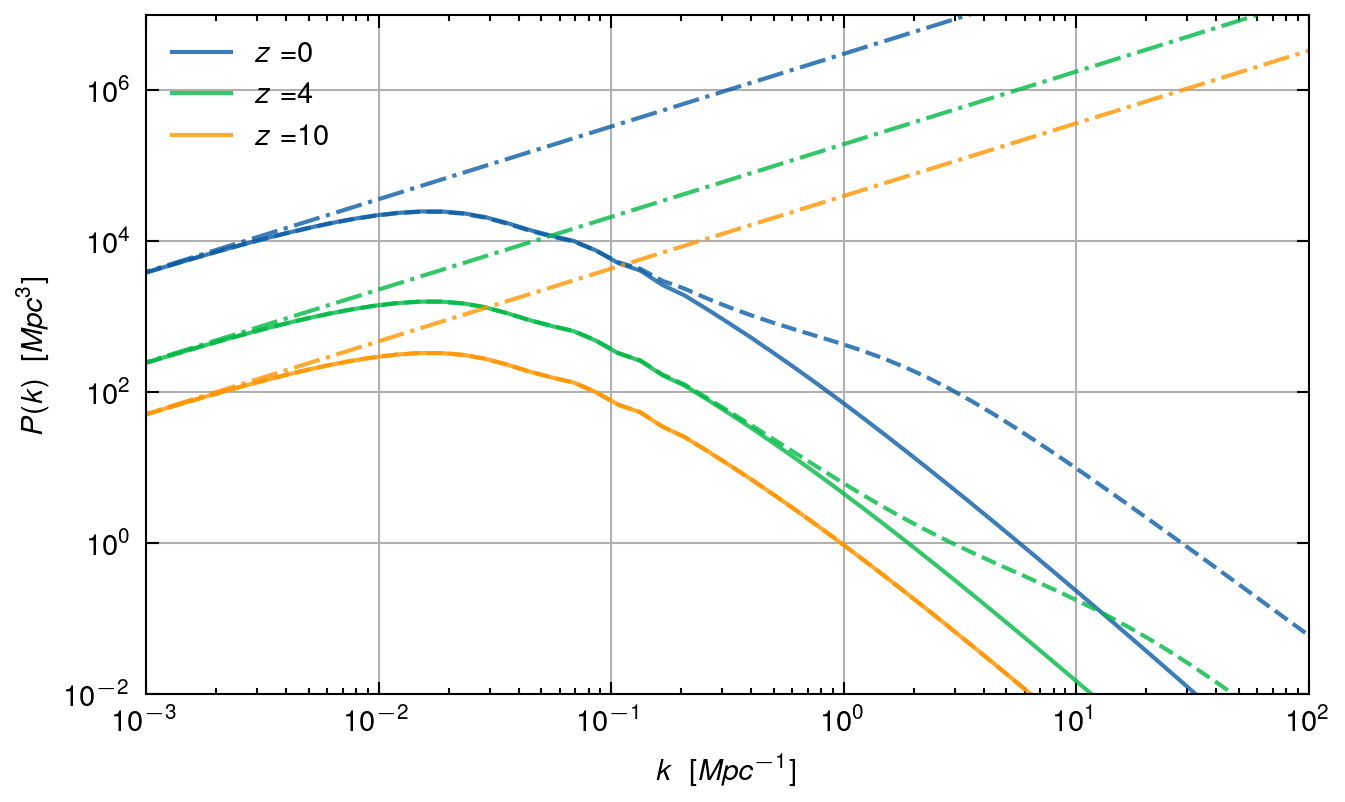

In [42]:
# Power Spectrum Plots
i=0
for z_value in [0, 4, 10]:
    k_l,pk_l,k_nl,pk_nl = generate_all_power_spectra(Omega_m,Omega_b,h,n_s,sigma8,z_value, sta_k=-4, end_k=2, class_reso=2 ** 6)
    col = colors[i]
    plt.loglog(k_l,pk_l,c=col, label="$z = $" + str(z_value),alpha=0.8)
    plt.loglog(k_nl,pk_nl,c=col,linestyle = "dashed",alpha=0.8)
    scaling = pk_l[0] / np.power(k_l[0],n_s)
    plt.loglog(k_l,scaling*np.power(k_l,n_s),c=col,linestyle = "dashdot",alpha=0.8)
    i += 1
plt.grid()
plt.legend()
plt.xlim([1e-3, 1e2])
plt.ylim([1e-2, 1e7])
plt.ylabel("$P(k) \ \ [Mpc^3]$")
plt.xlabel("$k \ \ [Mpc^{-1}]$")
plt.savefig("Powerspectrum.jpg")
plt.show()

generating power spectra ... (this will take time) ...
Done!
generating power spectra ... (this will take time) ...
Done!
generating power spectra ... (this will take time) ...
Done!
generating power spectra ... (this will take time) ...
Done!
generating power spectra ... (this will take time) ...
Done!
generating power spectra ... (this will take time) ...


No handles with labels found to put in legend.


Done!
generating power spectra ... (this will take time) ...
Done!


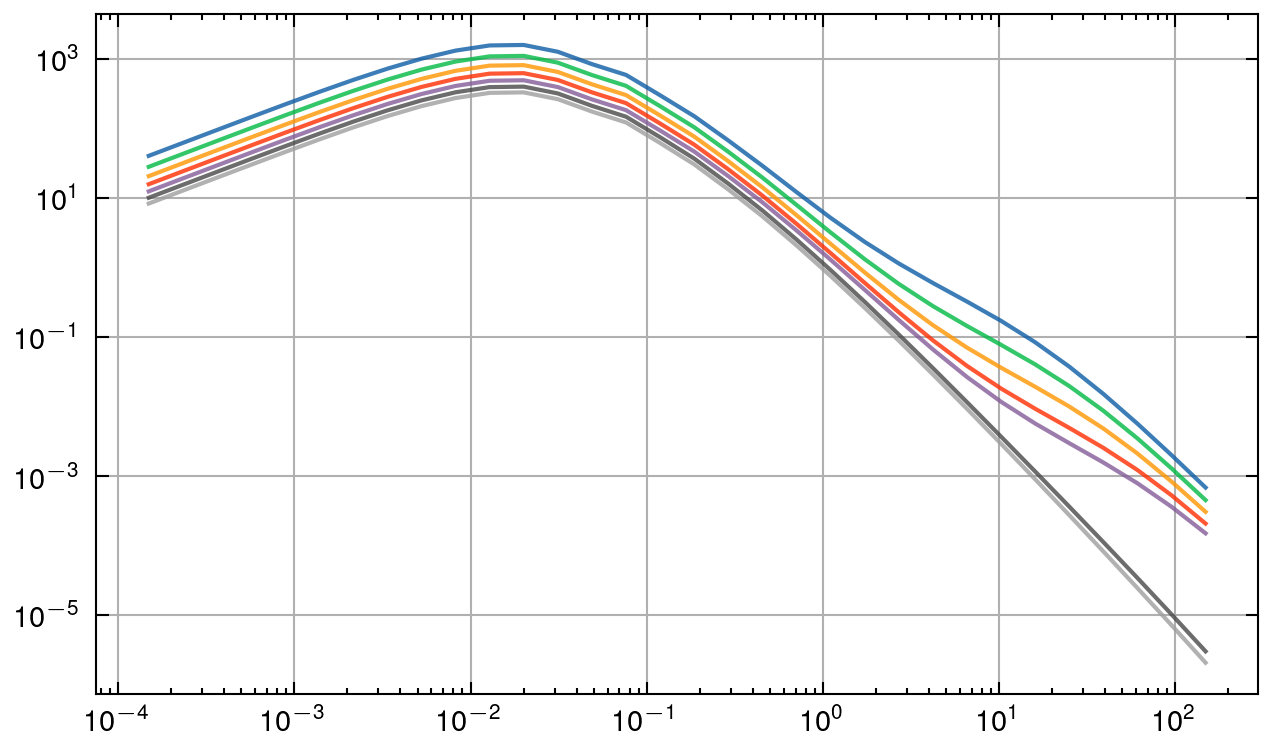

In [44]:
# Power Spectrum Plots
for z_value in [4, 5, 6, 7, 8, 9, 10]:
    k_l,pk_l,k_nl,pk_nl = generate_all_power_spectra(Omega_m,Omega_b,h,n_s,sigma8,z_value, sta_k=-4, end_k=2, class_reso=2 ** 5)
    plt.loglog(k_nl,pk_nl,alpha=0.8)
plt.grid()
plt.legend()
plt.show()

In [2]:

cat = fits.open('DES0500-6331_y1a1_gold.fits')
# dens = dens[0].data
# # fdens = np.reshape(dens, [1, np.prod(dens.shape)])
# HR4 = np.histogram(dens, density=True, bins = 100)
# HR4_delta = np.array([(HR4[1][i+1]-HR4[1][i])/2 + (HR4[1][i]) for i in range(len(HR4[1])-1)])
# HR4_pdf = HR4[0]
# del dens,HR4#,fdens

In [3]:
# print(cat[1].data)
dat = cat[1].data

In [4]:
cat.info()

Filename: DES0500-6331_y1a1_gold.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    188   141157R x 79C   ['K', 'D', 'D', '12A', 'I', 'K', 'E', 'E', 'E', 'E', 'D', 'I', 'I', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'I', 'I', 'I', 'J', 'J', 'J', 'J', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   


In [5]:
cat.close()

In [6]:
print(dat[0])

(3053591387, 74.614958, -63.848577, 'DES0500-6331', 1, 2172196373, 274.04666, -36.508076, 1.2230037, 1.1691726, 0.03164, 0, 17, 4.095859, 0.1992, -0.0251, -0.0614, -0.1348, -0.1667, 1, 1, 1, 1, 1, 44, 23, 57, 29, 60, 328.02032, 693.4831, 817.4688, 873.7755, 797.84717, 30.303045, 42.865513, 91.00055, 204.49782, 660.6593, 23.7102, 22.8974, 22.7188, 22.6465, 22.7452, 0.1003, 0.0671, 0.1209, 0.8993, 0.2542, 23.2667, 22.7545, 22.6873, 22.3186, 99.0, 0.0819, 0.0093, 0.0784, 0.162, 99.0, 24.110203, 22.746447, 22.668427, 22.087206, 21.246803, -0.00243, -0.0066, 0.00125, -0.00905, -0.02057, 0.00293, 0.00185, 0.00316, 0.00669, 0.02256, -0.00243, -0.00071, 0.00125, -0.02057, -0.00905)


In [7]:
print(dat.field(1))

[74.614958 74.605871 74.393338 ... 75.049892 75.132901 75.482051]


In [5]:
ind = dat.field(0)
r = dat.field(1)
c = dat.field(2)

In [6]:
plt.rcParams["figure.figsize"] = [5,5]

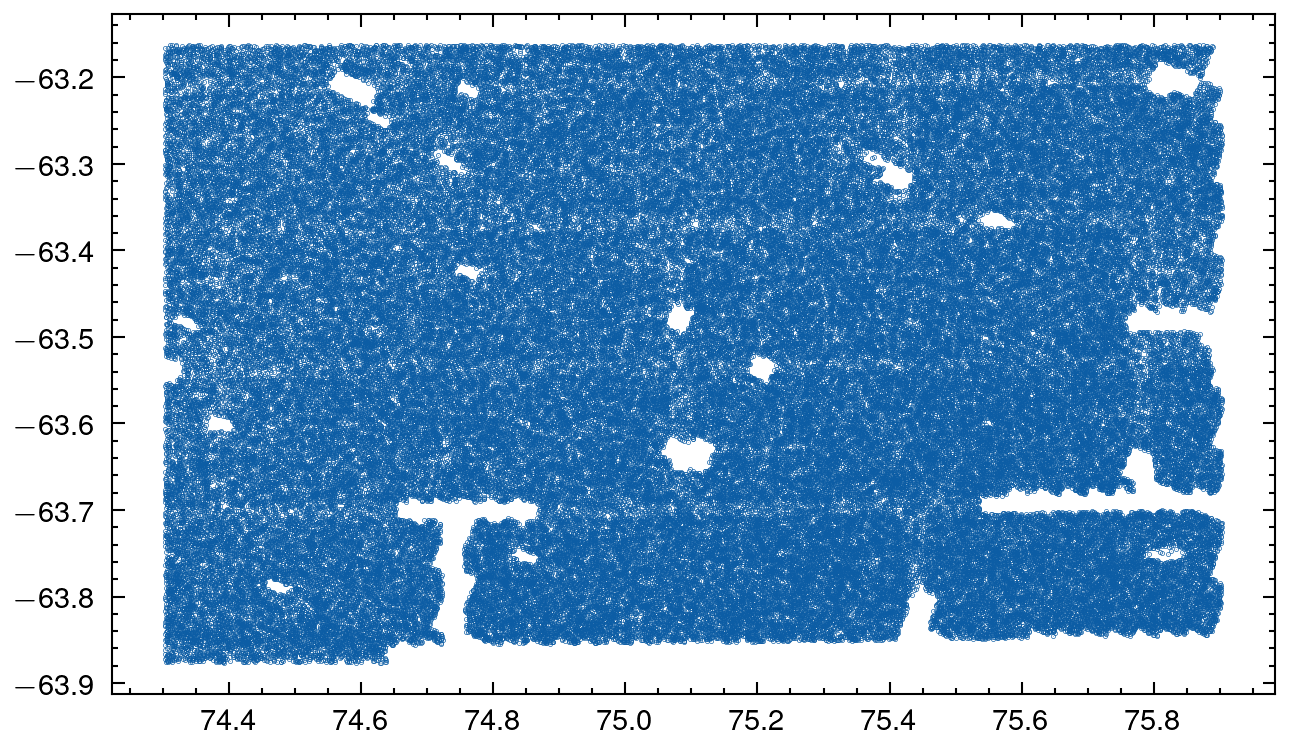

In [10]:
plt.scatter(r,c,s=0.1,marker='.')
# plt.scatter(rr,cc,s=0.1,marker='.',c='r')
# plt.xlim([75.25, 75.55])
# plt.ylim([-63.7, -63.4])

In [9]:
import numpy as np
import scipy.ndimage as ndi

data = np.random.rand(30000,2)           ## create random dataset
inds = (data * 255).astype('uint')       ## convert to indices

img = np.zeros((256,256))                ## blank image
for i in xrange(data.shape[0]):          ## draw pixels
    img[inds[i,0], inds[i,1]] += 1

img = ndi.gaussian_filter(img, (10,10))

NameError: name 'xrange' is not defined

In [45]:
interest = ind[np.where((r>= 75.25) & (r<=75.55) & (c>= -63.7) & (c<= -63.4))]

for i in ind:
    if np.where(inte)
rr = r[np.where(ind == interest)]
cc = c[np.where(ind == interest)]

/scratch-local/slurm-job-tmp-3958375/ipykernel_98/2439298504.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  rr = r[np.where(ind == interest)]
/scratch-local/slurm-job-tmp-3958375/ipykernel_98/2439298504.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  cc = c[np.where(ind == interest)]


In [57]:
interest.shape

(12930,)

In [14]:
import numpy as np
from matplotlib import pyplot as plt

def gaussianSum1D(gridpoints, datapoints, sigma=5):

    a = np.exp( -((gridpoints[:,None]-datapoints)/sigma)**2 )

    return a

#some test data
x = np.array(rr)
y = np.array(cc)

#create grids
gridSize = 60703
xedges = np.linspace(np.min(x), np.max(x), gridSize)
yedges = np.linspace(np.min(y), np.max(y), gridSize)

#calculate weights for both dimensions seperately
a = gaussianSum1D(xedges, x, sigma=2)
b = gaussianSum1D(yedges, y, sigma=0.1)

Z = np.dot(a, b.T).T

#plot original data
fig, ax = plt.subplots()
ax.scatter(x, y, s = 1)
#overlay data with contours 
ax.contour(xedges, yedges, Z, cmap = "jet")

ValueError: shapes (60703,28165) and (60703,60703) not aligned: 28165 (dim 1) != 60703 (dim 0)

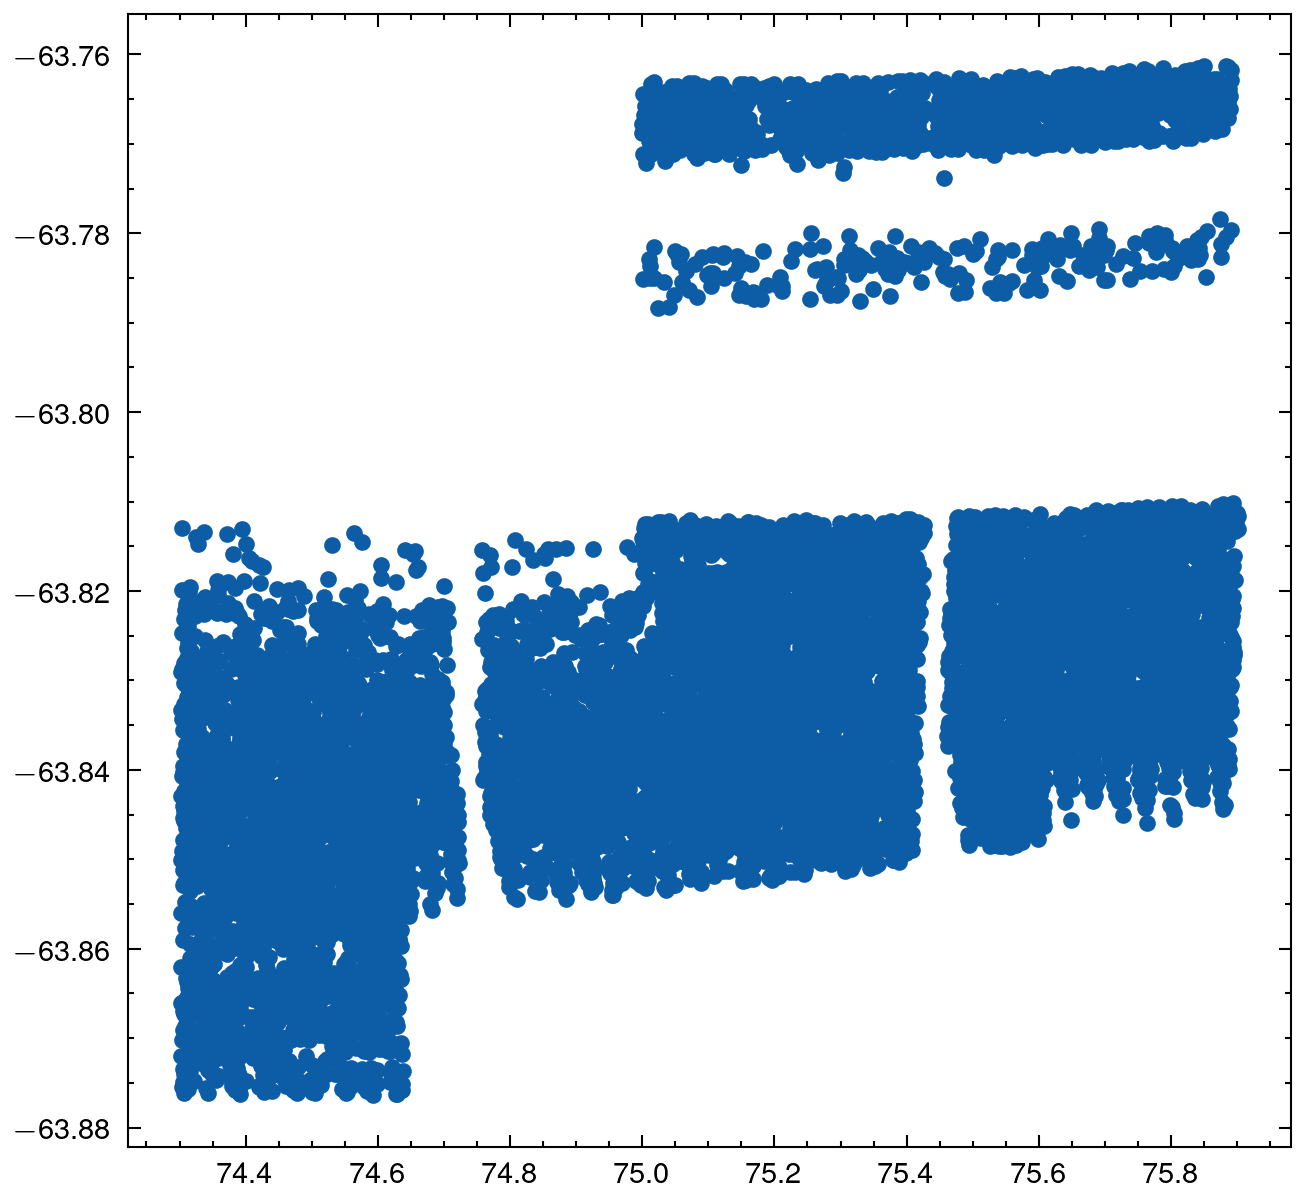

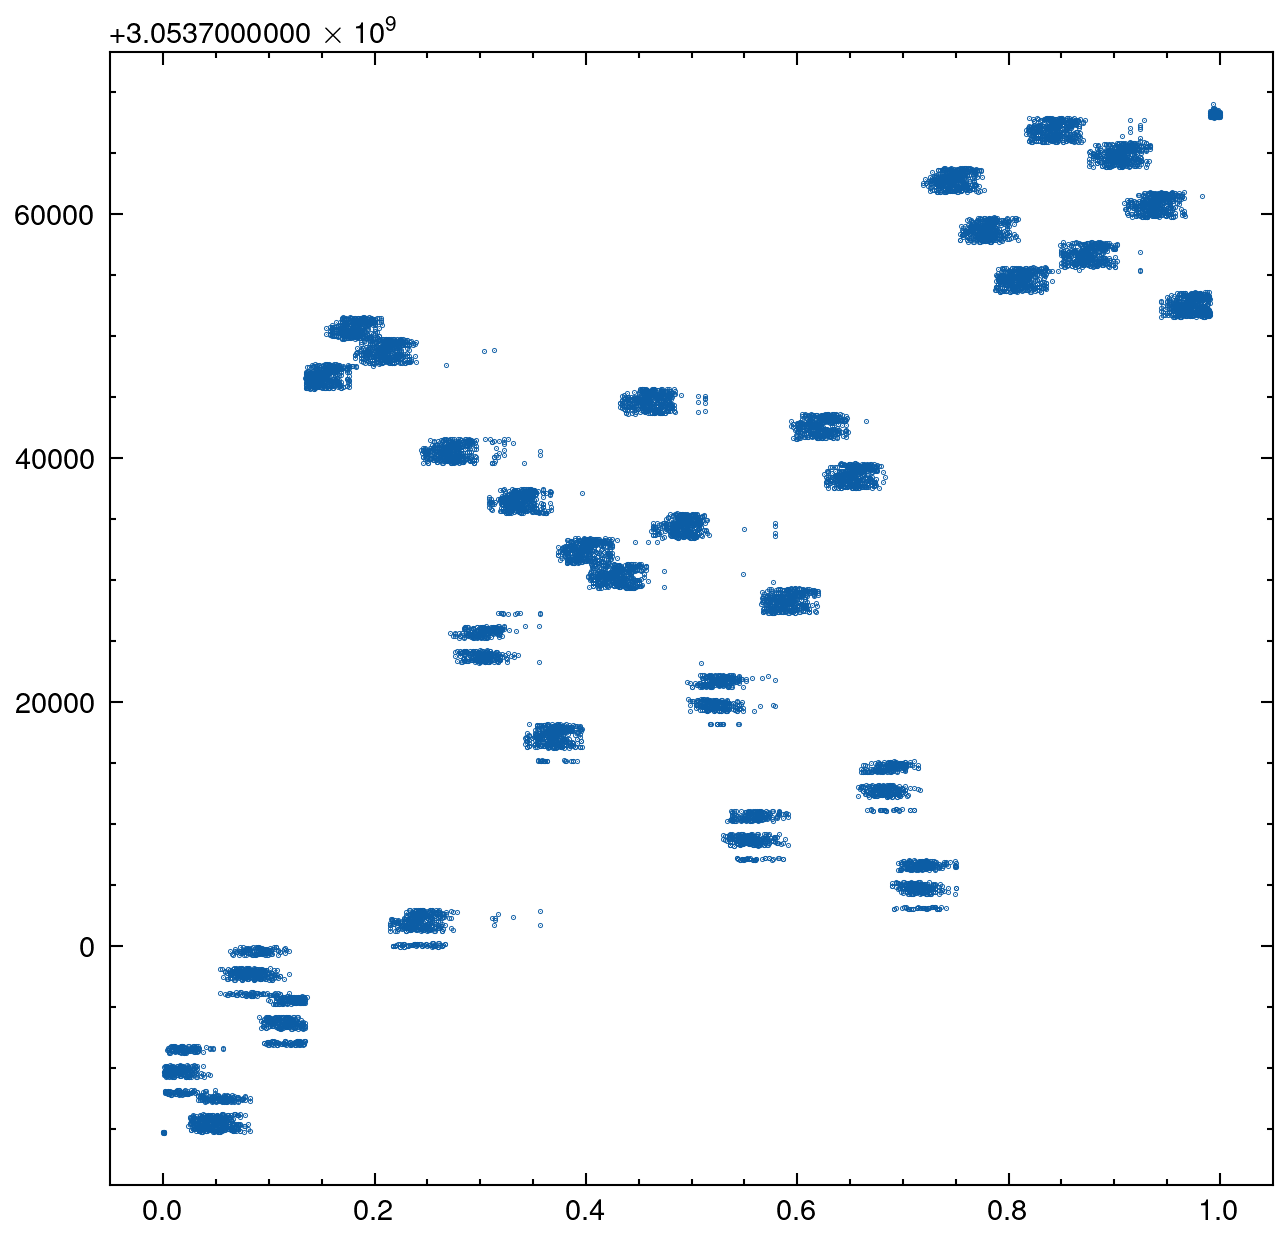

In [55]:
plt.scatter(np.linspace(0,1,len(interest)),interest,s=0.05)

In [42]:
ind.shape

(141157,)